In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

In [2]:
import rubin_scheduler

In [3]:
import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline

import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.db as db

/Users/duncan/Documents/code/physics/repos/rubin_sim/rubin_sim/utils/__init__.py:6: DeprecationWarning: rubin_sim.utils is deprecated, switch to rubin_scheduler.utils
  warnings.warn("rubin_sim.utils is deprecated, switch to rubin_scheduler.utils", DeprecationWarning)


In [4]:
import sys

In [5]:
import importlib

In [6]:
maf = importlib.reload(sys.modules["rubin_sim"]).maf

In [8]:
from numba import njit
import rubin_sim.data
import os
from tqdm.notebook import tqdm

In [9]:
from LensCalcPy.pbh import Pbh
from LensCalcPy.galaxy import MilkyWayModel
import LensCalcPy.eventsampling as es
import LensCalcPy.pbh

/Users/duncan/Documents/code/physics/microlensing/LensCalcPy/LensCalcPy/interpolations/interps.py:7: DeprecationWarning: Please import `interp2d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.
  ut_interp = pickle.load(f)
/Users/duncan/Documents/code/physics/microlensing/LensCalcPy/LensCalcPy/interpolations/interps.py:10: DeprecationWarning: Please import `interp2d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.
  ut_interp_mw = pickle.load(f)


In [10]:
importlib.reload(LensCalcPy)
Pbh = importlib.reload(sys.modules["LensCalcPy.pbh"]).Pbh
MilkyWayModel = importlib.reload(sys.modules["LensCalcPy.galaxy"]).MilkyWayModel


In [11]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

from matplotlib.cm import ScalarMappable

In [16]:
# os.environ['RUBIN_SIM_DATA_DIR']='/home/d/duncanw/DATA/rubin_sim_data'

In [12]:
basedir = '/Volumes/thesis/rubin-sim/userdata/opsim_ml/'

In [13]:
sources = pd.read_pickle(basedir+"rand_tristar_1000000.pickle")

In [14]:
ds = kpc_from_mu0(sources['mu0'].to_numpy())
plt.hist(ds, bins=np.linspace(0,50,200));
plt.yscale('log')

NameError: name 'kpc_from_mu0' is not defined

In [16]:
@njit
def wrap_degrees(x):
    x = (x + 180) % 360
    return (x - 180)
@njit
def kpc_from_mu0(mu0):
    return np.power(10, mu0/5.+1-3)
@njit
def mu0_from_kpc(kpc):
    return 5*(np.log10(kpc) + 3. - 1. )

In [82]:
mu0_from_kpc(np.array([35,40]))

array([17.72034022, 18.01029996])

In [16]:
mw = MilkyWayModel()
pbh = Pbh(mass=1, f_dm=1, mw_model=mw, l=0, b=0, u_t=2, ds=8)
def source_lensing_rate(pbh, l, b, ds):
    pbh.l=l
    pbh.b=b
    pbh.ds=ds
    return pbh.rate_total(pbh.differential_rate_integrand_mw, tcad = 0, tobs = 24*365*10, \
               epsabs = 1.49e-08, epsrel = 1.49e-08, efficiency=None) 

In [17]:
def differential_rate_mw(l, b, ds, t, mw_model, u_t=2, mass=1, finite=True, v_disp=None, t_e=True, tmax=np.inf, tmin=0):
    def integrand_func(umin, dl, t):
        return LensCalcPy.pbh.differential_rate_integrand(l, b, dl, ds, umin, t, u_t, mass, mw_model, finite=finite, v_disp=v_disp, t_e = t_e, tmax=tmax, tmin=tmin)
    return LensCalcPy.pbh.differential_rate(ds, mass, u_t, t, integrand_func, finite=finite)

In [18]:
def differential_rate_integrand_mw_maker(l, b, ds, u_t, mass, mw_model, finite=True, v_disp=None, t_e=True, tmax=np.inf, tmin=0):
    def differential_rate_integrand_mw(umin, dl, t, finite=True):
            # return self.differential_rate_integrand(umin, d, t, self.mw_model, finite=finite)
        return LensCalcPy.pbh.differential_rate_integrand(l, b, dl, ds, umin, t, u_t, mass, mw_model, finite=finite, v_disp=v_disp, t_e = t_e, tmax=tmax, tmin=tmin)
    return differential_rate_integrand_mw
def source_lensing_rate(l, b, ds, mw_model, u_t=5, mass=1,tcad = 24, tobs = 24*365*10, \
               epsabs = 1.49e-08, epsrel = 1.49e-08, efficiency=None) :
    return LensCalcPy.pbh.rate_total(ds, mass, u_t, differential_rate_integrand_mw_maker(l, b, ds, u_t, mass, mw_model), tcad = tcad, tobs = tobs, \
               epsabs =epsabs, epsrel = epsrel, efficiency=efficiency) 

In [17]:
import csv
import time
import os
from pathlib import Path
import glob

In [18]:
import warnings

In [19]:
catalog = result = sources

In [103]:
u_t=5
# basedir= f"{os.getenv('HOME')}/rubin-user/data/opsim_ml"
rates_file = f'{basedir}/rates_ml_rates_{int(np.ceil(time.time()))}_ut-{u_t}_m-10.csv'
basepath = Path(basedir)
basepath.mkdir(parents=True, exist_ok=True)
rates = {}
try: 
    raise Exception
    old_rates_file = max(glob.glob(basedir+f'/ml_rates_*ut-{u_t}*')) # get most recent

    with open(old_rates_file, 'r') as f:
        print(f'opened {old_rates_file}')
        reader = csv.reader(f)
        next(reader) #skip header
        for line in reader:
            rates[tuple(float(_) for _ in line[:-1])]=float(line[-1])
    
except: 
    pass
    # for i in range(len(result)):
    with open(rates_file, 'x') as f:
        writer = csv.writer(f)
        writer.writerow(("l","b","mu0","ML rate (1/hour)"))
    for i in tqdm(range(len(result)),smoothing=0):
        l,b,mu0 = result.iloc[i][['gall', 'galb', 'mu0']]
        ds = kpc_from_mu0(mu0)
        # print(ds)
        with warnings.catch_warnings(action="ignore"):
            rates[(l,b,mu0)] = source_lensing_rate(l, b, ds, mw, u_t=u_t, mass=10)
        with open(rates_file, 'a') as f:
            writer = csv.writer(f)
            writer.writerow((l,b,mu0,rates[(l,b,mu0)]))

  0%|          | 0/1000192 [00:00<?, ?it/s]

In [1]:
basepath.exist()

NameError: name 'basepath' is not defined

In [23]:
u_t=5
partialratesfile = glob.glob(f'{basedir}/rates_ml_rates_*_te-True_ut-{u_t}.csv')[0]

In [40]:
def get_partial_rates(filename):
    lastkey = ()
    rates = {}
    with open(filename, 'r') as f:
        _=next(f)
        for line in f:
            lastline = line
            l,b,mu0,rate = [float(_) for _ in line.replace('\n',',').split(',') if len(_)>0]
            rates[(l,b,mu0)] = rate
            lastkey = (l,b,mu0) 
    return rates, lastkey

def get_last_vals(filename):
    return [float(_) for _ in get_last_line(filename).replace('\n',',').split(',') if len(_)>0]


In [38]:
rates, lastkey = get_partial_rates(partialratesfile)

In [26]:
rates[lastkey]

5.373963947066555e-10

In [34]:
source_lensing_rate(l, b, 8, mw, u_t=u_t)

6.213114161859829e-11

In [28]:
source_lensing_rate(l, b, 8, mw, u_t=u_t)

/Users/duncan/Documents/code/physics/microlensing/LensCalcPy/LensCalcPy/utils.py:298: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  return ut_interp_rho(rho, A_thresh)
/Users/duncan/mambaforge/envs/rubinsim/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:611: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return _quadpack._qagse(func,a,b,args,full_output

6.213114161859829e-11

In [39]:
l,b,mu0 = lastkey
np.arange(0,len(result))[(result['gall']==l) & (result['galb']==b) & (result['mu0']==mu0)][-1]

604307

In [53]:
import warnings


In [21]:
def continue_rates_calc(partialratesfile, u_t=5):

    try:
        rates, lastkey = get_partial_rates(partialratesfile)
    except e:
        print('no such file: ' + partialratesfile)
        return

    del rates
    l,b,mu0 = lastkey
    lastwritten = np.arange(0,len(result))[(result['gall']==l) & (result['galb']==b) & (result['mu0']==mu0)][-1]
    for i in tqdm(range(len(result)),smoothing=0):
        if i <= lastwritten:
            continue
        l,b,mu0 = result.iloc[i][['gall', 'galb', 'mu0']]
        ds = kpc_from_mu0(mu0)
        # print(ds)
        # rates[(l,b,mu0)] = source_lensing_rate(l, b, ds, mw, u_t=u_t)

        rate = source_lensing_rate(l, b, ds, mw, u_t=u_t)
        with open(partialratesfile, 'a') as f:
            writer = csv.writer(f)
            writer.writerow((l,b,mu0,rate))
    # return rates

In [50]:
len(rates)

604312

In [57]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [58]:
with warnings.catch_warnings(action="ignore"):
    continue_rates_calc('/Volumes/thesis/rubin-sim/userdata/opsim_ml/rates_ml_rates_1718083107_te-True_ut-5 copy.csv')

  0%|          | 0/1000192 [00:00<?, ?it/s]

In [66]:
%%prun -s tottime 
with warnings.catch_warnings(action="ignore"):
    source_lensing_rate(l, b, 8, mw, u_t=5)

         66024 function calls (64176 primitive calls) in 0.041 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     9261    0.011    0.000    0.015    0.000 4027543284.py:2(differential_rate_integrand_mw)
     9261    0.004    0.000    0.004    0.000 pbh.py:358(differential_rate_integrand)
      541    0.003    0.000    0.005    0.000 _fitpack_impl.py:612(bisplev)
      441    0.003    0.000    0.017    0.000 {built-in method scipy.integrate._quadpack._qagse}
      541    0.002    0.000    0.012    0.000 _interpolate.py:301(__call__)
      541    0.002    0.000    0.016    0.000 utils.py:292(ut_func_new)
     2705    0.002    0.000    0.003    0.000 shape_base.py:23(atleast_1d)
    463/1    0.001    0.000    0.037    0.037 _quadpack_py.py:1254(integrate)
    463/1    0.001    0.000    0.037    0.037 _quadpack_py.py:22(quad)
    442/1    0.001    0.000    0.037    0.037 _quadpack_py.py:968(nquad)
      541    0.001    0.000 

In [86]:
rates

{(147.44455933570862, -35.17942869473673, 19.0): 3.6988310946270475e-10,
 (149.30102348327637, -35.270543216872355, 10.15): 1.1680283874223641e-11,
 (244.0732258558273, -18.40937683364227, 17.55): 3.1336056109270735e-10,
 (257.9020518064499, 4.026084378065832, 14.4): 5.0296965890561585e-11,
 (243.4521335363388, 5.3177665238292064, 13.0): 3.155466988046536e-11,
 (228.9315068721771, -0.0345744196769147, 13.3): 3.0428987227391636e-11,
 (239.9502843618393, 4.347058585503319, 12.1): 2.9475404251742604e-11,
 (199.3079781532288, -4.419492873388549, 10.05): 1.059965386607398e-11,
 (191.37749612331388, 7.888945862235744, 10.55): 1.5048569846612223e-11,
 (334.9863409996032, 25.33534469436832, 15.05): 2.0669580862066932e-10,
 (342.3915606737136, 2.120902891555332, 14.5): 1.848684866931551e-10,
 (344.4534015655517, 1.8772672906374623, 14.85): 2.9550691379189497e-10,
 (349.9574339389801, 5.992740978265672, 15.8): 1.0308454380499353e-09,
 (350.55632293224335, 5.478972816038734, 14.35): 1.86539920848

In [87]:
n_tristar = 11433322690
n_survey_events = round(sum(rates.values())*n_tristar/len(rates.values())*24*365*10)
print(n_survey_events)

336265


In [17]:
n_survey_events=445916

In [22]:
n_tristar = 11_433_322_690
n_survey_events = round(sum(rates.values())*n_tristar/len(rates.values())*24*365*10)
print(n_survey_events)

336265


In [104]:
n_tristar = 11_433_322_690
n_survey_events = round(sum(rates.values())*n_tristar/len(rates.values())*24*365*10)
print(n_survey_events)

140559


In [105]:
336265/140559

2.392340582958046

In [88]:
# @njit
def sample_density_single_source(params, # galactic longitude (degrees)
                 # b, # galactic latitide (degrees)
                 # dl,  # lens distance from Earth (kpc)
                 # ds,  # source distance from Earth (kpc)
                 mw_model, # LensCalcPy.galaxy object
                 source_catalog, # DataFrame from TRIStar catalog
                 catalog_size, 
                 lbounds=(-180,180),
                 bbounds=(-90,90),
                 mass=1,
                 u_t=2,
                 **lcp_params
                 #umin=.5 # minimum impact parameter - u=2 ~50 mmag
):
    """
    Compute density of microlensing event space in differential volume.

    Parameters
    ----------
    params : np.array
       l  - galactic longitude (degrees)
       b  - galactic latitide (degrees) 
       dl - lens distance from Earth (kpc)
       ds - source distance from Earth (kpc)
       umin - minimum impact parameter
       crossing time - timescale of microlensing event

    lbounds : tuple(float, float)
        bounds on galactic longitude in degrees
    bbounds : tuple(float, float)
        bounds on galactic latitude in degrees

    Returns
    -------
    float
        Event rate in (hours)**-(2) * (kpc)**(-2)
    """
    
    source_index, dl, umin, crossing_time = params
    source_index = int(np.floor(source_index))
    if source_index >= catalog_size or source_index < 0:
        return 0
    l,b,mu0 = source_catalog.iloc[source_index][['gall', 'galb', 'mu0']]
    l = wrap_degrees(l)
    b = wrap_degrees(b)
    # ds = np.power(10, mu0/5.-3)
    ds = kpc_from_mu0(mu0)
    # l, b, dl, ds, umin, crossing_time = params
    if l < lbounds[0] \
    or l > lbounds[1] \
    or b > bbounds[1] \
    or b < bbounds[0] \
    or dl < 0 or dl > ds \
    or umin <= 0 \
    or crossing_time <= 0:
        return 0
    prob = LensCalcPy.pbh.differential_rate_integrand(l, b, dl, ds, umin, crossing_time, u_t, mass, mw_model,**lcp_params)
    if prob < 0 or np.isnan(prob):
        return 0
    return prob

def sample_density_single_source_log(params, # galactic longitude (degrees)
                 # b, # galactic latitide (degrees)
                 # dl,  # lens distance from Earth (kpc)
                 # ds,  # source distance from Earth (kpc)
                 mw_model, # LensCalcPy.galaxy object
                 source_catalog, # DataFrame from TRIStar catalog
                 catalog_size, 
                 lbounds=(-180,180),
                 bbounds=(-90,90),
                 mass=1,
                 u_t=2,
                 **lcp_params):
    density = sample_density_single_source(params, mw_model, source_catalog, catalog_size, lbounds, bbounds, mass, u_t, **lcp_params)
    if density==0.:
        return -np.inf
    else:
        return np.log(density)

In [89]:
p0 = []
for i in range(1):
    source_index = np.random.randint(0,len(sources))
    mu0 = sources.iloc[source_index]['mu0']
    ds = kpc_from_mu0(mu0)
    p0.append([source_index, ds*np.random.random(), 1, 100])
    

In [ ]:
p0[0]
mu0 = sources.iloc[p0[0][0]]['mu0']
ds = np.power(10, mu0/5.-3)
new_lograte = np.log(ds)+sample_density_single_source_log(p0[0], # galactic longitude (degrees)
                 mw, # LensCalcPy.galaxy object
                 sources, # DataFrame from TRIStar catalog
                 len(sources),
                 u_t=5,
                 mass=1)

In [26]:
np.log(0)

/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_20868/2933082444.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(0)


-inf

In [91]:
run_label='full'
u_t = 5
t_min = 24
t_max = 24*365*10
nsteps=round(n_survey_events/100)
ntoss=10000
# nsteps=10000
headers=['source_index', 'dl', 'umin', 'crossing_time', 'lograte']

# basedir= f"{os.getenv('HOME')}/rubin-user/data/opsim_ml"
events_file = f'{basedir}/ml_events_{nsteps}_toss-{ntoss}_{int(np.ceil(time.time()))}_{run_label}_ut-{u_t}_m-1.csv'
basepath = Path(basedir)
basepath.mkdir(parents=True, exist_ok=True)
with open(events_file, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    

samples = [p0[0]+[new_lograte]]
i = 0 
n_proposed = 0
for i in tqdm(range(nsteps+ntoss), smoothing=0):
    
    source_index, dl, umin, crossing_time, lograte = samples[-1]    
    if i == ntoss: # clear the events after generating enough to throw out
        samples = []
    while True:
        new_source_index = np.random.choice(np.arange(len(sources)))    
        new_l,new_b,new_mu0 = sources.iloc[source_index][['gall', 'galb', 'mu0']]
        ds = kpc_from_mu0(new_mu0)
        new_dl = np.random.random()*ds # put lens uniformly random between earth and source
        new_umin = np.random.random()*u_t # limit to photometric repeatability limit for dim sources
        # new_crossing_time = t_min + np.random.random()*t_max # limit between daily cadence and full survey length
        new_crossing_time = t_min * np.power(t_max/t_min, np.random.random()) # limit between daily cadence and full survey length
        new_event=[new_source_index, new_dl, new_umin, new_crossing_time]
        new_lograte =  sample_density_single_source_log(new_event, # galactic longitude (degrees)
                 mw, # LensCalcPy.galaxy object
                 sources, # DataFrame from TRIStar catalog
                 len(sources),
                 u_t=u_t,
                 t_e=True) \
                + np.log(ds) \
                + np.log(new_crossing_time)
        #print(f'{lograte} vs {new_lograte}')
        n_proposed += 1
        if new_lograte > lograte or np.exp(new_lograte - lograte) > np.random.random():
            samples.append(new_event+[new_lograte])
            if i >= ntoss: # only write values you're not going to toss
                with open(events_file, 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow(samples[-1])
            break


  0%|          | 0/13363 [00:00<?, ?it/s]

In [92]:
n_proposed

207450

In [28]:
basedir

'/Volumes/thesis/rubin-sim/userdata/opsim_ml/'

In [22]:
u_t = 5
# basedir= f"{os.getenv('HOME')}/rubin-user/data/opsim_ml"
thisdir = basedir
events_file = f'{thisdir}/ml_events_*_ut-{u_t}.pickle'
old_events_file = max(glob.glob(events_file)) # get most recent
print(old_events_file)

/Volumes/thesis/rubin-sim/userdata/opsim_ml/ml_events_4459_toss-10000_1709245261_centi_ut-5.pickle


In [23]:
event_df = pd.read_pickle(old_events_file)

In [93]:
event_df = pd.DataFrame(samples, columns=['source_index', 'dl', 'umin', 'crossing_time', 'lograte'])

In [60]:
events_file.split('.')[0]+'.pickle'

'/home/d/duncanw/rubin-user/data/opsim_ml/ml_events_445916_toss-10000_1709345829_full_ut-5.pickle'

In [94]:
event_df.to_pickle(events_file.split('.')[0]+'.pickle')

In [41]:
rates_file = '/Volumes/thesis/rubin-sim/userdata/opsim_ml/rates_ml_rates_1718083107_te-True_ut-5.csv'
# with open(rates_file, 'r') as f:
rates, _ = get_partial_rates(rates_file)
    

In [42]:
rates

{(147.44455933570862, -35.17942869473673, 19.0): 3.6988310946270475e-10,
 (149.30102348327637, -35.270543216872355, 10.15): 1.1680283874223627e-11,
 (244.0732258558273, -18.40937683364227, 17.55): 3.133605610927086e-10,
 (257.9020518064499, 4.026084378065832, 14.4): 5.029696589056142e-11,
 (243.4521335363388, 5.3177665238292064, 13.0): 3.1554669880465375e-11,
 (228.9315068721771, -0.0345744196769147, 13.3): 3.042898722739165e-11,
 (239.9502843618393, 4.347058585503319, 12.1): 2.947540425174262e-11,
 (199.3079781532288, -4.419492873388549, 10.05): 1.0599653866073969e-11,
 (191.37749612331388, 7.888945862235744, 10.55): 1.504856984661221e-11,
 (334.9863409996032, 25.33534469436832, 15.05): 2.0669580862066836e-10,
 (342.3915606737136, 2.120902891555332, 14.5): 1.8486848669315445e-10,
 (344.4534015655517, 1.8772672906374623, 14.85): 2.9550691379189393e-10,
 (349.9574339389801, 5.992740978265672, 15.8): 1.0308454380499306e-09,
 (350.55632293224335, 5.478972816038734, 14.35): 1.8653992084841

In [20]:
# event_df = pd.read_pickle(basedir+'/ml_events_252723_1708114636_full.pickle')
events_file = '/Volumes/thesis/rubin-sim/userdata/opsim_ml/ml_events_336265_toss-20000_1721087495_full_ut-5_m-1.pickle'
event_df = pd.read_pickle(events_file)

In [37]:
event_df = pd.read_pickle(events_file.split('.')[0]+'.pickle')

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/thesis/rubin-sim/userdata/opsim_ml//ml_events_*_ut-5.pickle'

In [23]:
samples_arr = event_df.to_numpy()

In [22]:
event_df

source_index        dl      umin  crossing_time    lograte
0             655637  6.795839  4.566752    3637.845333 -24.581774
1             714774  7.277394  4.013819     489.623730 -23.282106
2             954024  6.352935  1.688565    1770.543617 -23.982610
3             256566  7.354947  1.977935    2160.927335 -22.776930
4              19834  6.330344  2.372521     684.788963 -20.294885
...              ...       ...       ...            ...        ...
336260        257893  2.657990  2.528075     676.104618 -21.782683
336261        830126  5.044992  3.127621     660.612697 -20.581815
336262        197041  9.082070  2.746745    1106.451897 -22.248939
336263        778180  5.209179  4.076738     570.813318 -22.016124
336264        919203  2.693515  1.456075     519.819643 -23.288375

[336265 rows x 5 columns]

In [21]:
catalog=sources

In [41]:
catalog.columns

Index(['ra', 'dec', 'gall', 'galb', 'elon', 'elat', 'm_ini', 'logage', 'm_h',
       'mu0', 'av', 'mratio', 'mass', 'logl', 'logte', 'logg', 'mcoretp',
       'c_o', 'period0', 'period1', 'period2', 'period3', 'period4', 'mloss',
       'tau1m', 'x', 'y', 'xc', 'xn', 'xo', 'cexcess', 'z', 'mbolmag', 'umag',
       'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'gaia_gmag', 'g_bpmag',
       'g_rpmag', 'velu', 'velv', 'velw', 'vrad', 'pmracosd', 'pmdec',
       'random_id', 'htm9', 'ring256', 'nest4096', 'gc', 'label', 'pmode'],
      dtype='object')

In [24]:
event_source_df = catalog.iloc[samples_arr[:,0]][['ra','dec', 'gall', 'galb', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'ymag','mu0']].reset_index()

In [25]:
event_source_df

index          ra        dec        gall       galb    umag    gmag  \
0       655637  260.856917 -28.999457  357.317040   4.046521  27.603  24.977   
1       714774  212.758532 -64.175997  311.467407  -2.631304  26.991  23.642   
2       954024   81.571713 -69.574242  280.202639 -32.688944  24.970  24.035   
3       256566   80.074765 -67.885223  278.329959 -33.517497  25.170  24.090   
4        19834  261.149336 -19.526680    5.399930   9.083362  31.826  28.438   
...        ...         ...        ...         ...        ...     ...     ...   
336260  257893    8.628692 -73.316459  304.612241 -43.756538  27.890  26.393   
336261  830126  261.678737 -42.405030  346.578661  -4.017430  30.201  26.629   
336262  197041  261.023940  -7.761019   15.531975  15.451137  30.692  27.878   
336263  778180  256.228643 -43.921955  343.033360  -1.659722  31.890  28.454   
336264  919203  274.890197 -19.086631   12.386350  -1.862383  28.880  25.651   

          rmag    imag    zmag    ymag     mu0  
0       23.438  22.617  22.010  21.679  15.400  
1       21.749  20.747  20.002  19.593  15.100  
2       23.657  23.521  23.473  23.456  18.487  
3       23.635  23.457  23.368  23.329  18.455  
4       26.490  25.330  24.633  24.269  15.100  
...        ...     ...     ...     ...     ...  
336260  25.735  25.473  25.352  25.285  19.034  
336261  24.712  23.663  23.014  22.658  14.800  
336262  26.296  25.504  24.989  24.704  16.050  
336263  26.051  24.703  23.687  23.118  14.800  
336264  23.521  22.325  21.415  20.914  14.300  

[336265 rows x 12 columns]

In [26]:
full_event_df = event_df.merge(event_source_df, how='inner', left_index=True, right_index=True)
full_event_df

source_index        dl      umin  crossing_time    lograte   index  \
0             655637  6.795839  4.566752    3637.845333 -24.581774  655637   
1             714774  7.277394  4.013819     489.623730 -23.282106  714774   
2             954024  6.352935  1.688565    1770.543617 -23.982610  954024   
3             256566  7.354947  1.977935    2160.927335 -22.776930  256566   
4              19834  6.330344  2.372521     684.788963 -20.294885   19834   
...              ...       ...       ...            ...        ...     ...   
336260        257893  2.657990  2.528075     676.104618 -21.782683  257893   
336261        830126  5.044992  3.127621     660.612697 -20.581815  830126   
336262        197041  9.082070  2.746745    1106.451897 -22.248939  197041   
336263        778180  5.209179  4.076738     570.813318 -22.016124  778180   
336264        919203  2.693515  1.456075     519.819643 -23.288375  919203   

                ra        dec        gall       galb    umag    gmag    rmag  \
0       260.856917 -28.999457  357.317040   4.046521  27.603  24.977  23.438   
1       212.758532 -64.175997  311.467407  -2.631304  26.991  23.642  21.749   
2        81.571713 -69.574242  280.202639 -32.688944  24.970  24.035  23.657   
3        80.074765 -67.885223  278.329959 -33.517497  25.170  24.090  23.635   
4       261.149336 -19.526680    5.399930   9.083362  31.826  28.438  26.490   
...            ...        ...         ...        ...     ...     ...     ...   
336260    8.628692 -73.316459  304.612241 -43.756538  27.890  26.393  25.735   
336261  261.678737 -42.405030  346.578661  -4.017430  30.201  26.629  24.712   
336262  261.023940  -7.761019   15.531975  15.451137  30.692  27.878  26.296   
336263  256.228643 -43.921955  343.033360  -1.659722  31.890  28.454  26.051   
336264  274.890197 -19.086631   12.386350  -1.862383  28.880  25.651  23.521   

          imag    zmag    ymag     mu0  
0       22.617  22.010  21.679  15.400  
1       20.747  20.002  19.593  15.100  
2       23.521  23.473  23.456  18.487  
3       23.457  23.368  23.329  18.455  
4       25.330  24.633  24.269  15.100  
...        ...     ...     ...     ...  
336260  25.473  25.352  25.285  19.034  
336261  23.663  23.014  22.658  14.800  
336262  25.504  24.989  24.704  16.050  
336263  24.703  23.687  23.118  14.800  
336264  22.325  21.415  20.914  14.300  

[336265 rows x 17 columns]

Text(0.5, 0, 'Lens distance (kpc)')

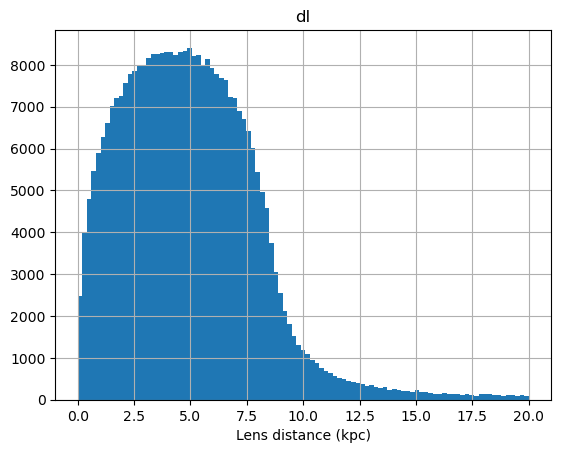

In [27]:
full_event_df.hist('dl', bins=np.linspace(0,20,100))
plt.xlabel('Lens distance (kpc)')

In [28]:
df = full_event_df

Text(0.5, 0, 'umin')

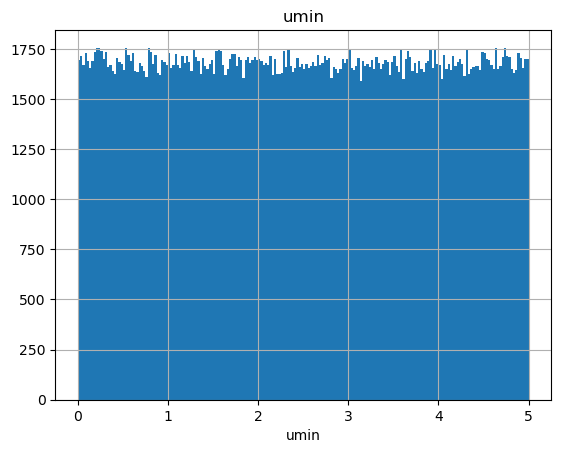

In [29]:
df.hist('umin', bins=200)
plt.xlabel('umin')

Text(0.5, 0, 'Crossing time (hours)')

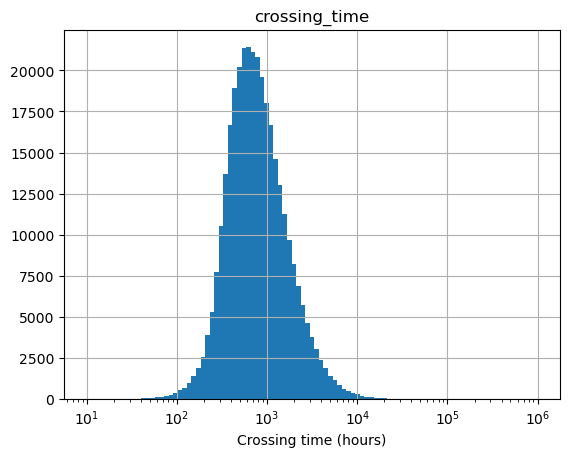

In [30]:
df.hist('crossing_time', bins=np.logspace(1, 6, 100))
plt.xscale('log')

plt.xlabel('Crossing time (hours)')

Text(0.5, 0, 'Crossing time (hours)')

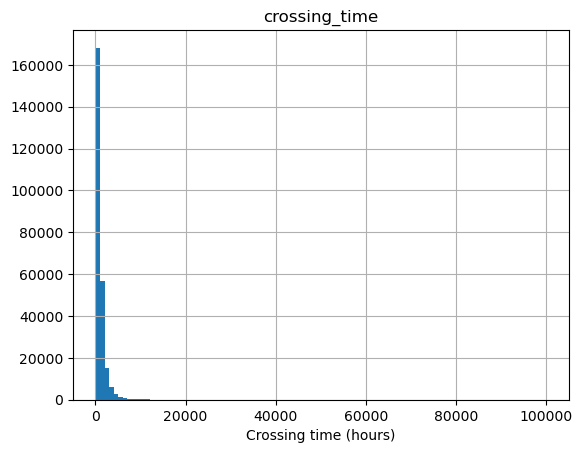

In [49]:
df.hist('crossing_time', bins=np.linspace(10**1, 10**5, 100))
# plt.xscale('log')

plt.xlabel('Crossing time (hours)')

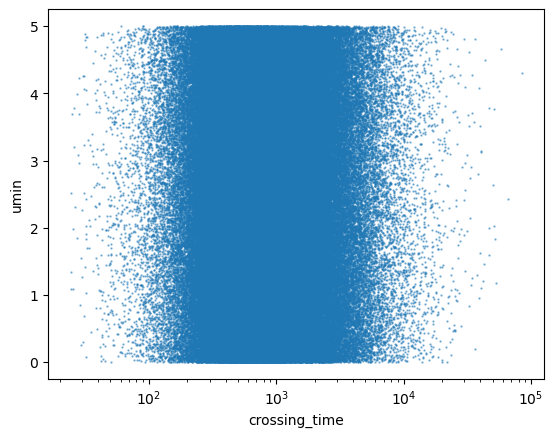

In [31]:
df.plot.scatter('crossing_time', 'umin', s=.5,alpha=.5)
plt.xscale('log')
# plt.yscale('log')

In [51]:
t_max

NameError: name 't_max' is not defined

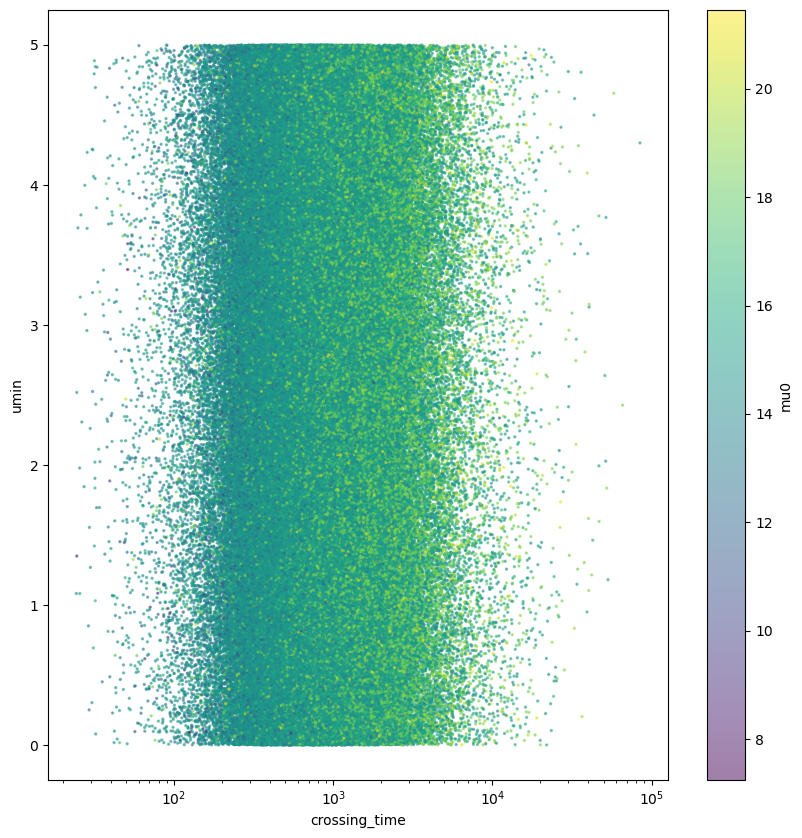

In [32]:
fig,ax = plt.subplots(figsize=(10,10))
df.plot.scatter('crossing_time', 'umin',c='mu0',s=2,alpha=.5, ax=ax)
plt.xscale('log')
# plt.yscale('log')

Text(0, 0.5, 'dl')

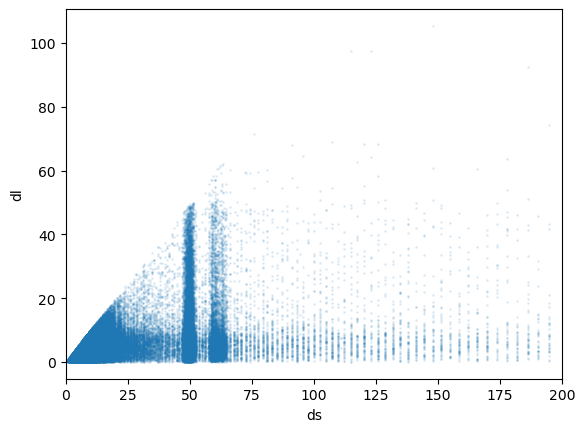

In [72]:
ds = kpc_from_mu0(df['mu0'].to_numpy())
plt.scatter(ds, df['dl'],alpha=.1,s=1)
plt.xlim(0,200)
plt.xlabel('ds')
plt.ylabel('dl')

Text(0.5, 1.0, 'Galactic sources and lenses toward LMC')

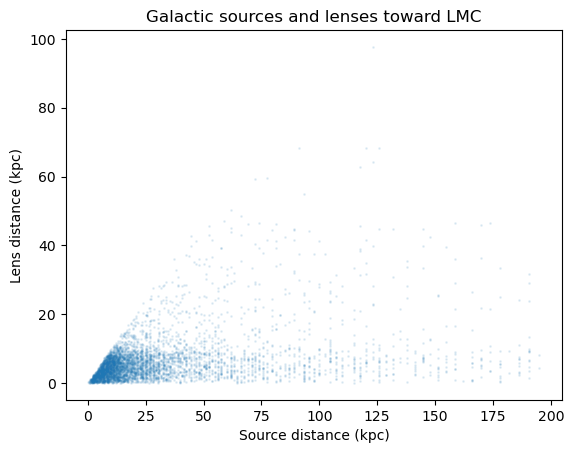

In [71]:
lmcdf = df[(df['galb']>-60) &(df['galb']<-20) & (df['gall']<260) & (df['gall']<310)]
ds = kpc_from_mu0(lmcdf['mu0'].to_numpy())
plt.scatter(ds, lmcdf['dl'],alpha=.1,s=1)
# plt.xlim(0,75)
plt.xlabel('Source distance (kpc)')
plt.ylabel('Lens distance (kpc)')
plt.title('Galactic sources and lenses toward LMC')

In [ ]:
df[df['crossing_time'] < .5*10**3].plot.scatter('ra', 'dec', s=1, c='umin')
# plt.xscale('log')

In [ ]:
df[df['crossing_time'] < .1*10**3].plot.scatter('ra', 'dec', s=1, c='mu0')
# plt.xscale('log')

In [ ]:
df[df['umin'] > 1.99].plot.scatter('ra', 'dec', s=1, c='umin')
# plt.xscale('log')

In [ ]:
df[df['umin'] < 1.99].plot.scatter('ra', 'dec', s=1, c='umin')
# plt.xscale('log')

In [ ]:
catalog.iloc[samples_arr[:,0]].plot.scatter(x='ra',y='dec', alpha=.1, marker='.')

In [ ]:
plt.plot(samples_arr[1:,4], linestyle='None', marker='.', markersize=1)

In [ ]:
samples_arr[:,4]

In [ ]:
catalog.iloc[samples_arr[:,0]].plot.scatter(x='ra',y='dec', alpha=.005, marker=".")
plt.title('Map of microlensing events, 40x oversampled')

Text(0, 0.5, 'Number of sources')

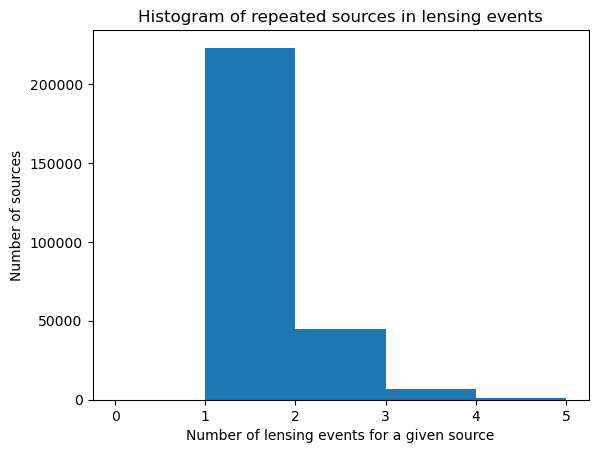

In [33]:
# indices_sorted = np.sort(samples_arr[:,0])
unique_sources, source_counts = np.unique(samples_arr[:,0], return_counts=True)
plt.hist(source_counts, np.arange(0,np.max(source_counts), 1))
plt.title('Histogram of repeated sources in lensing events')
plt.xlabel('Number of lensing events for a given source')
plt.ylabel('Number of sources')

<Axes: xlabel='gall', ylabel='galb'>

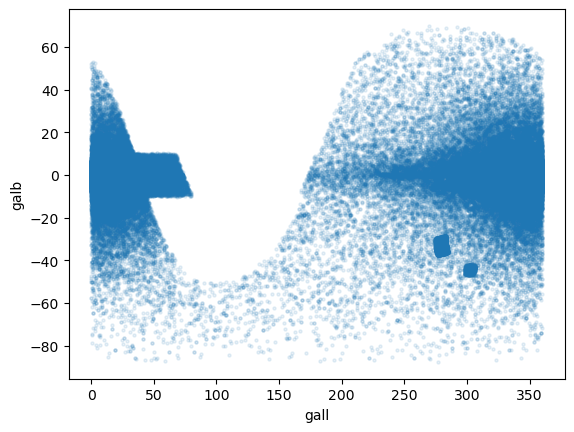

In [64]:
catalog.iloc[samples_arr[:,0]].plot.scatter(x='gall',y='galb', alpha=.1, marker='.')

In [43]:
rate_arr = np.array(list(rates.values()))
rate_sort = np.argsort(rate_arr)

In [66]:
result.shape[0]

1000192

In [34]:
class MLRateMetric(maf.BaseMetric):
    def __init__(self):
        # Set the columns we want from the database
        super().__init__(col=["fieldRA", "fieldDec", "HA"], metric_name="mlrate")

    def run(self, data_slice, slice_point=None):
        # print("--- run ----")
        # print(
        #     f"data_slice is a {type(data_slice)} of dtype {data_slice.dtype} with a shape of {data_slice.shape}"
        # )
        # print(f"slice_point is a {type(slice_point)} with value: {slice_point}")

        # Calculate the metric value here, using any values
        # you like from the dataSlice and slicePoint arguments.
        metric_value_for_this_slice = rate_arr[slice_point["index"]]
        return metric_value_for_this_slice

In [35]:
ml_metric = MLRateMetric()

In [36]:
baseline_file = get_baseline()
opsim = os.path.basename(baseline_file).replace('.db','')
print(f'running on {opsim}')

running on baseline_v3.3_10yrs


In [44]:
bundle_rates = {}
slicer = slicers.UserPointsSlicer(result['ra'],result['dec'], lat_lon_deg=True, badval=0)
slicer.slice_points["index"]=np.asarray(np.arange(result.shape[0]))
bundle_rates['rates'] = maf.MetricBundle(ml_metric, slicer, None, run_name=opsim,  
                                            info_label=f'Microlensing rate (1/hour)')

In [45]:
outDir = 'microlensing_rates'
g = maf.MetricBundleGroup(bundle_rates, baseline_file, outDir)
g.run_all()

KeyboardInterrupt: 

In [ ]:
# plotDict = {'reduce_func': lambda x : 24*365*10*np.sum(x), 'nside': 64, 'color_min': 0, 'color_max': .001}
plotDict = {'reduce_func': np.sum, 'nside': 64, 'color_min': 0, 'color_max': 10**(-7)}
plotFunc = maf.plots.HealpixSkyMap()
ph = maf.plots.PlotHandler(out_dir=outDir, thumbnail=False)

ph.set_metric_bundles([bundle_rates['rates']])
ph.plot(plot_func=plotFunc, plot_dicts=plotDict)

## Set up and run the microlensing metric. ## 

The microlensing metric is similar to the KNe metric, in that it requires a microlensing-specific slicer (a UserPoints slicer combined with information about the microlensing events and lightcurves) together with the microlensing detection metric. 

The population distribution for the microlensing metric is currently a simple N^2 distribution of events (N being the stellar density at that point in the sky). Events occur with a variety of crossing times, and evaluation of the detection likelilhood in the metric is split up between different intervals; in general longer crossing times are easier to detect and can overwhelm the detection sensitivity to shorter timescale events.

In [46]:
baseline_file = get_baseline()
opsim = os.path.basename(baseline_file).replace('.db','')
print(f'running on {opsim}')

running on baseline_v3.3_10yrs


In [47]:
metric = maf.MicrolensingMetric()
summaryMetrics = maf.batches.lightcurve_summary()

In [48]:
filters = [ col for col in full_event_df.columns if 'mag' in col ]

In [49]:
filters

['umag', 'gmag', 'rmag', 'imag', 'zmag', 'ymag']

In [50]:
# metric??

In [51]:
# n_events = 10000 
bundles = {}
resultDbs = {}
# Let's evaluate a variety of crossing times
# crossing_times = [[1, 5,], [5, 10], [10, 20], [20, 30], [30, 60], [60, 90], [100, 200], [200, 500], [500, 1000]]
crossing_times = [[0, 30000]]
seed = 42
rng = np.random.default_rng(seed)
t_start, t_end = 1, 3652
for crossing in crossing_times:
    key = f'{crossing[0]} to {crossing[1]}'
    # slicer = maf.generate_dm_microlensing_slicer(min_crossing_time=crossing[0], max_crossing_time=crossing[1], 
    #                                         n_events=n_events, initial_states='/home/d/duncanw/repos/LensCalcPy/nbs/eventsamples.pkl')
    bundle_rates = {}
    slicer = slicers.UserPointsSlicer(full_event_df['ra'].array,full_event_df['dec'].array, lat_lon_deg=True, badval=0)
    slicer.slice_points["crossing_time"]=full_event_df['crossing_time'].array/24
    slicer.slice_points["impact_parameter"]=full_event_df['umin'].array
    slicer.slice_points["peak_time"]= rng.uniform(low=t_start, high=t_end, size=len(full_event_df))
    for filter in filters:
        filtername = filter[0]
        slicer.slice_points["apparent_m_no_blend_{}".format(filtername)] = full_event_df[filter].array
        slicer.slice_points["apparent_m_{}".format(filtername)] = full_event_df[filter].array
    bundle_rates['rates'] = maf.MetricBundle(metric, slicer, None, run_name=opsim,  
                                            info_label=f'Microlensing rate (1/hour)')
    bundles[key] = maf.MetricBundle(metric, slicer, None, run_name=opsim, 
                                            summary_metrics=summaryMetrics, 
                                            info_label=f'tE {crossing[0]}_{crossing[1]} days')

In [52]:
slicer.slice_points

{'sid': array([     0,      1,      2, ..., 336262, 336263, 336264]),
 'ra': array([4.55281208, 3.7133369 , 1.42369497, ..., 4.55572718, 4.47203346,
        4.79773901]),
 'dec': array([-0.506136  , -1.12008245, -1.2142996 , ..., -0.13545534,
        -0.76658273, -0.33312456]),
 'gall': array([6.23635883, 5.43613178, 4.89045864, ..., 0.27108411, 5.98706158,
        0.2161826 ]),
 'galb': array([ 0.07062512, -0.04592491, -0.5705297 , ...,  0.26967321,
        -0.02896761, -0.03250472]),
 'crossing_time': <NumpyExtensionArray>
 [ 151.5768888600519,  20.40098876445167,  73.77265072404094,
   90.03863895527418, 28.532873455884882,   74.4479738836176,
   80.83786280098475, 11.369639577011574,  30.01042255754636,
   24.56543483313074,
  ...
   25.49864277646621, 52.297143781957715,  39.11702194922306,
   42.49477866986678,  73.17650162331891, 28.171025754162503,
  27.525529021230124,  46.10216237865487,  23.78388823842089,
  21.659151810946383]
 Length: 336265, dtype: float64,
 'impact_param

In [53]:
outDir = 'test_microlensing_dm_rubinsim_1sm'
g = maf.MetricBundleGroup(bundles, baseline_file, outDir)

In [54]:
g.run_all()

In [38]:
bundles.keys()

dict_keys(['0 to 30000'])

In [138]:
g.db_cols

['observationStartMJD',
 'fiveSigmaDepth',
 'rotSkyPos',
 'night',
 'fieldRA',
 'filter',
 'fieldDec']

In [140]:
g.db_table()

TypeError: 'NoneType' object is not callable

In [137]:
dir(g)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_compatible',
 '_find_compatible_lists',
 '_run_compatible',
 'bundle_dict',
 'compatible_lists',
 'constraints',
 'current_bundle_dict',
 'db_cols',
 'db_obj',
 'db_table',
 'get_data',
 'has_run',
 'out_dir',
 'plot_all',
 'plot_current',
 'read_all',
 'reduce_all',
 'reduce_current',
 'results_db',
 'run_all',
 'run_current',
 'save_early',
 'set_current',
 'sim_data',
 'summary_all',
 'summary_current',
 'verbose',
 'write_all',
 'write_current']

## Running Number of Points microlensing metric

It may also be useful as an estimate of characterization efficiency to calculate the number of points observed close to the peak of the event. When you specify metricCalc = 'Npts', the metric calculates the total number of points within two Einstein crossing times of the peak of the event

In [229]:
metric_Npts = maf.MicrolensingMetric(metric_calc = 'Npts')
summaryMetrics = maf.batches.microlensing_summary(metric_type = 'Npts')

In [233]:
n_events = 10000 
bundles_Npts = {}
# Let's evaluate a variety of crossing times
crossing_times = [[0,30000]]
for crossing in crossing_times:
    key = f'{crossing[0]} to {crossing[1]}'
    # slicer = maf.generate_microlensing_slicer(min_crossing_time=crossing[0], max_crossing_time=crossing[1], 
    #                                         n_events=n_events)
    # bundles_Npts[key] = maf.MetricBundle(metric_Npts, slicer, None, run_name=opsim, 
    #                                         summary_metrics=summaryMetrics, 
    #                                         info_label=f'tE {crossing[0]}_{crossing[1]} days')
    slicer = slicers.UserPointsSlicer(full_event_df['ra'].array,full_event_df['dec'].array, lat_lon_deg=True, badval=0)
    slicer.slice_points["crossing_time"]=full_event_df['crossing_time'].array/24
    slicer.slice_points["impact_parameter"]=full_event_df['umin'].array
    slicer.slice_points["peak_time"]= rng.uniform(low=t_start, high=t_end, size=len(full_event_df))
    bundles_Npts[key] = maf.MetricBundle(metric_Npts, slicer, None, run_name=opsim, 
                                            summary_metrics=summaryMetrics, 
                                            info_label=f'tE {crossing[0]}_{crossing[1]} days')

In [234]:
outDir = 'test_microlensing'
g = maf.MetricBundleGroup(bundles_Npts, baseline_file, outDir)

In [235]:
g.run_all()

## Running Fisher Information Matrix microlensing metric

In order to find the characterization efficiency more exactly, we can calculate the Fisher information matrix and find the $\sigma_{t_E}/{t_E}$ (where $t_E$ is the Einstein crossing time) for each event. Note that this is more computationally expensive

In [ ]:
import imp
imp.reload(maf.batches.common)

In [ ]:
metric_Fisher = maf.MicrolensingMetric(metric_calc = 'Fisher')
summaryMetrics = maf.batches.microlensing_summary(metric_type = 'Fisher')

In [ ]:
n_events = 10000 
bundles_Fisher = {}
# Let's evaluate a variety of crossing times
crossing_times = [[1, 5], [5, 10], [10, 20], [20, 30], [30, 60], [60, 90], [100, 200], [200, 500], [500, 1000]]
for crossing in crossing_times:
    key = f'{crossing[0]} to {crossing[1]}'
    slicer = maf.generate_microlensing_slicer(min_crossing_time=crossing[0], max_crossing_time=crossing[1], 
                                            n_events=n_events)
    bundles_Fisher[key] = maf.MetricBundle(metric_Fisher, slicer, None, run_name=opsim, 
                                            summary_metrics=summaryMetrics, 
                                            info_label=f'tE {crossing[0]}_{crossing[1]} days')

In [ ]:
outDir = 'test_microlensing'
g = maf.MetricBundleGroup(bundles_Fisher, baseline_file, outDir)

In [ ]:
g.run_all()

## Look at the metric outputs. ##

The default microlensing metric can output two different kinds of results; if 'detect' is True (the default), then it outputs 0-1 depending on whether an event was detected or not.

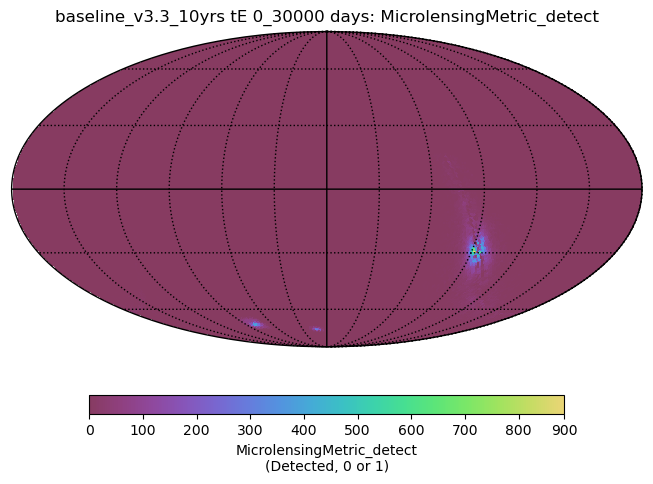

In [55]:
# If you don't want to try and plot N individual points, 
plotDict = {'reduce_func': np.sum, 'nside': 64, 'color_min': 0}
plotFunc = maf.plots.HealpixSkyMap()
ph = maf.plots.PlotHandler(out_dir=outDir, thumbnail=False)
for k in bundles:
    ph.set_metric_bundles([bundles[k]])
    ph.plot(plot_func=plotFunc, plot_dicts=plotDict)

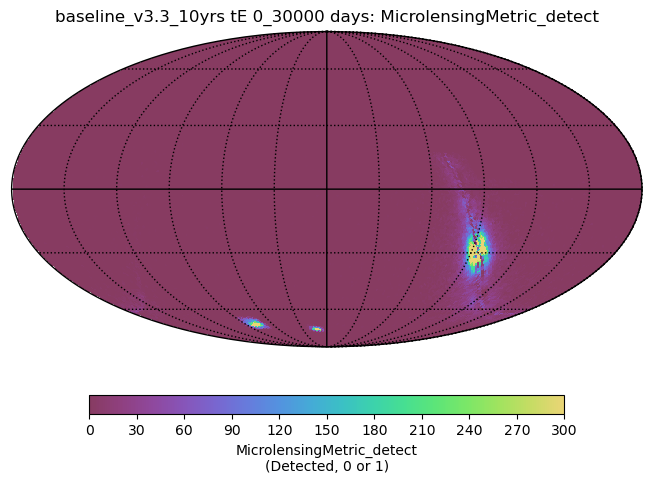

In [53]:
# If you don't want to try and plot N individual points, 
plotDict = {'reduce_func': np.sum, 'nside': 64, 'color_min': 0, 'color_max': 300}
plotFunc = maf.plots.HealpixSkyMap()
ph = maf.plots.PlotHandler(out_dir=outDir, thumbnail=False)
for k in bundles:
    ph.set_metric_bundles([bundles[k]])
    ph.plot(plot_func=plotFunc, plot_dicts=plotDict)

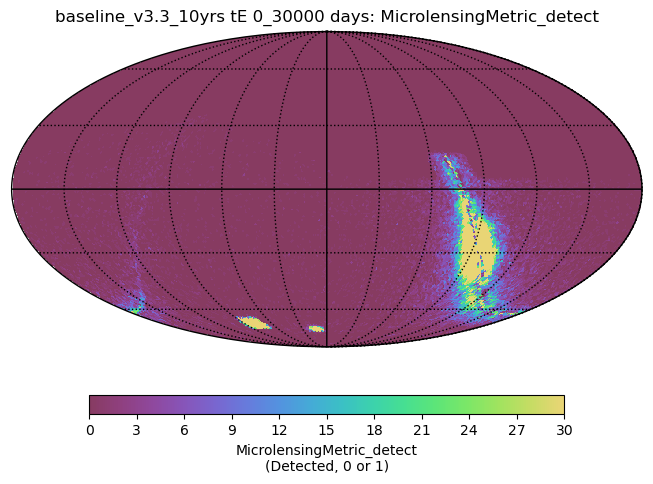

In [56]:
# If you don't want to try and plot N individual points, 
plotDict = {'reduce_func': np.sum, 'nside': 64, 'color_min': 0, 'color_max': 30}
plotFunc = maf.plots.HealpixSkyMap()
ph = maf.plots.PlotHandler(out_dir=outDir, thumbnail=False)
for k in bundles:
    ph.set_metric_bundles([bundles[k]])
    ph.plot(plot_func=plotFunc, plot_dicts=plotDict)

KeyboardInterrupt: 

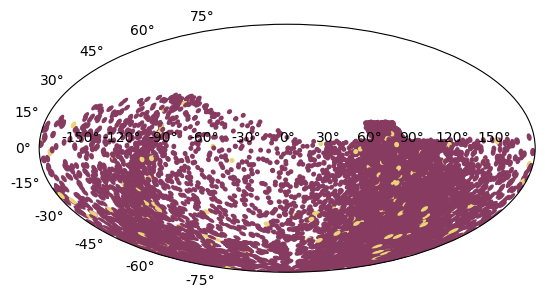

In [268]:
# If you do want to show each individual point - this is slower but shows each individual event
plotFunc = maf.plots.BaseSkyMap()

ph = maf.plots.PlotHandler(out_dir=outDir,  thumbnail=False)
for k in bundles:
    ph.set_metric_bundles([bundles[k]])
    ph.plot(plot_func=plotFunc)

In [57]:
d = pd.DataFrame([bundles[k].summary_values for k in bundles.keys()], index=list(bundles.keys()))
d

Total detected  Total lightcurves in footprint  \
0 to 30000        107910.0                          328766   

            Total lightcurves on sky  Fraction detected in footprint (mean)  \
0 to 30000                    336265                               0.328227   

            Fraction detected of total (mean)  
0 to 30000                           0.320908

In [58]:
list(bundles.values())[0].metric_values

masked_array(data=[0.0, 0.0, 1.0, ..., 0.0, 0.0, 0.0],
             mask=[False, False, False, ..., False, False, False],
       fill_value=0.0)

In [59]:
detections = list(bundles.values())[0].metric_values

In [60]:
np.sum(list(bundles.values())[0].metric_values)

107910.0

In [61]:
np.sum(list(bundles.values())[0].metric_values.mask)

7499

In [62]:
def rows_in_bin(df, col, min, max):
    return df[(df[col] >= min) & (df[col] < max)]

In [63]:
_ = rows_in_bin(full_event_df, 'crossing_time', 0,100)

In [64]:
def bin_efficiency(events: pd.DataFrame, detections, col, bins):
    detections_in_bins = []
    for i in range(len(bins)-1):
        l, r = bins[i],bins[i+1]
        events = rows_in_bin(full_event_df, col, l, r).index
        n_detected = np.sum(detections[events])
        n_not_detected = np.sum(detections[events] == 0)
        detections_in_bins.append([n_detected, n_not_detected])
    return np.asarray(detections_in_bins)

In [65]:
def bin_func(events: pd.DataFrame, col, bins, func, *args):
    bin_results = []
    for i in range(len(bins)-1):
        l, r = bins[i],bins[i+1]
        events = rows_in_bin(full_event_df, col, l, r)
        bin_results.append(func(events, *args))
    return bin_results
def mean_of_col(events, meancol):
    return events[meancol].to_numpy().mean()
def std_of_col(events, meancol):
    return events[meancol].to_numpy().std()
def perc_of_col(events, meancol, percentiles):
    col_vals = events[meancol].to_numpy()
    if col_vals.shape[0] > 0:
        return np.percentile(col_vals, percentiles)
    else:
        return np.full_like(percentiles, np.nan)


In [66]:
bins=np.logspace(1,5,4*8+1)
np.array(bin_func(full_event_df, 'crossing_time', bins, mean_of_col, ['rmag']))

/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_59274/2361972333.py:9: RuntimeWarning: Mean of empty slice.
  return events[meancol].to_numpy().mean()
/Users/duncan/mambaforge/envs/rubinsim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_59274/2361972333.py:9: RuntimeWarning: Mean of empty slice.
  return events[meancol].to_numpy().mean()
/Users/duncan/mambaforge/envs/rubinsim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_59274/2361972333.py:9: RuntimeWarning: Mean of empty slice.
  return events[meancol].to_numpy().mean()
/Users/duncan/mambaforge/envs/rubinsim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value enco

array([        nan,         nan,         nan, 24.05831034, 24.11310769,
       24.50246296, 24.43465595, 24.59954801, 24.50544236, 24.42122267,
       24.46694658, 24.52346221, 24.59929581, 24.71743564, 24.77530043,
       24.83246867, 24.8796133 , 24.91770013, 25.00061496, 25.01940085,
       25.07395825, 25.02895816, 25.09014101, 24.97966263, 24.9882207 ,
       25.17821875, 25.04211765, 24.8357234 , 25.17376923, 24.6047    ,
       25.046     , 26.559     ])

In [80]:
bins=np.logspace(1,5,4*8+1)
bin_detections = bin_efficiency(full_event_df, detections, 'crossing_time', bins)

/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_59274/4192803113.py:9: UserWarning: Warning: converting a masked element to nan.
  return np.asarray(detections_in_bins)


In [81]:
def compute_efficiency(det: np.array):
    return det[:,0]/(det[:,0] + det[:,1])

In [82]:
bins=np.logspace(1,5,4*8+1)
percentiles = [50+44.6,50-44.6]
bin_col = 'crossing_time'
y_col = 'umin'
# plt.figure(figsize=(15,10))
crossing_time_counts = np.array(bin_func(full_event_df, bin_col, bins, len))
print(crossing_time_counts)
# plt.bar(bins, crossing_time_counts, 

[    0     0     0    29    65   162   311   677  1544  3440  8030 19106
 36902 49906 52604 48768 39268 28809 19385 12184  7185  3920  2007   990
   512   256   119    47    26    10     2     1]


In [83]:
viridis = mpl.colormaps['viridis'].resampled(256)

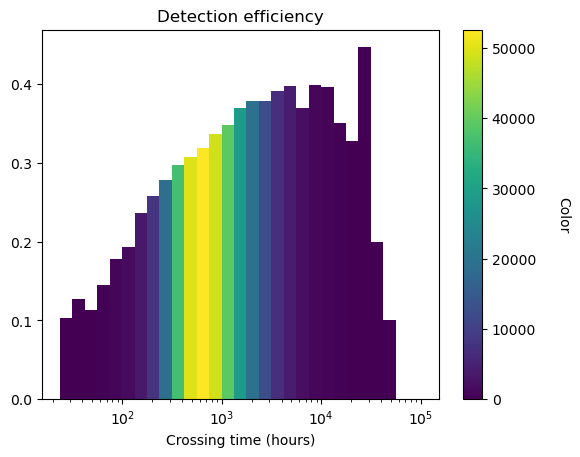

In [84]:
efficiencies = compute_efficiency(bin_detections)
fig, ax = plt.subplots(1,1)
bars = ax.bar(bins[:-1], efficiencies, width=bins[1:]-bins[:-1], align='edge', color=viridis(crossing_time_counts/np.max(crossing_time_counts)))
plt.xscale('log')
plt.title('Detection efficiency')
plt.xlabel('Crossing time (hours)')

sm = ScalarMappable(cmap=viridis, norm=plt.Normalize(0,np.max(crossing_time_counts)))
sm.set_array([])
cbar = plt.colorbar(sm,ax=ax)
cbar.set_label('Color', rotation=270,labelpad=25)
#psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
# fig.colorbar(im, ax=ax)

In [85]:
24*365*10

87600

In [86]:
bins=np.linspace(10,10**4,30)
bin_detections = bin_efficiency(full_event_df, detections, 'crossing_time', bins)

Text(0.5, 0, 'Crossing time (hours)')

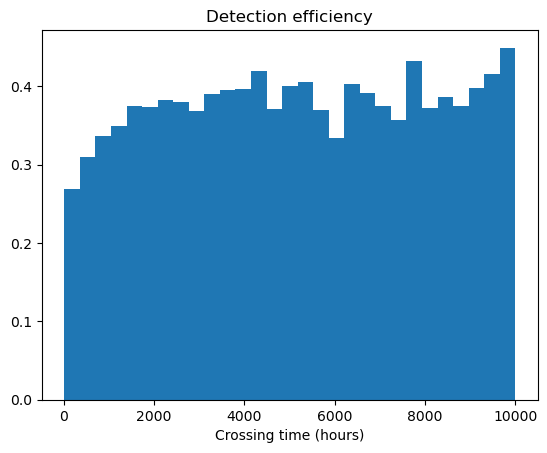

In [87]:
plt.bar(bins[:-1],bin_detections[:,0]/(bin_detections[:,0]+bin_detections[:,1]), width=bins[1:]-bins[:-1], align='edge')
# plt.xscale('log')
plt.title('Detection efficiency')
plt.xlabel('Crossing time (hours)')

In [88]:
single_exp_m5 = {
    'u':23.8, 
    'g':24.5,
    'r':24.03,
    'i':23.41,
    'z':22.74,
    'y':22.96}
color_filter = {
    'u':'blue',
    'g':'green',
    'r':'orange',
    'i':'red',
    'z':'brown',
    'y':'black'}
    

/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_59274/2361972333.py:9: RuntimeWarning: Mean of empty slice.
  return events[meancol].to_numpy().mean()
/Users/duncan/mambaforge/envs/rubinsim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_59274/2361972333.py:9: RuntimeWarning: Mean of empty slice.
  return events[meancol].to_numpy().mean()
/Users/duncan/mambaforge/envs/rubinsim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_59274/2361972333.py:9: RuntimeWarning: Mean of empty slice.
  return events[meancol].to_numpy().mean()
/Users/duncan/mambaforge/envs/rubinsim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value enco

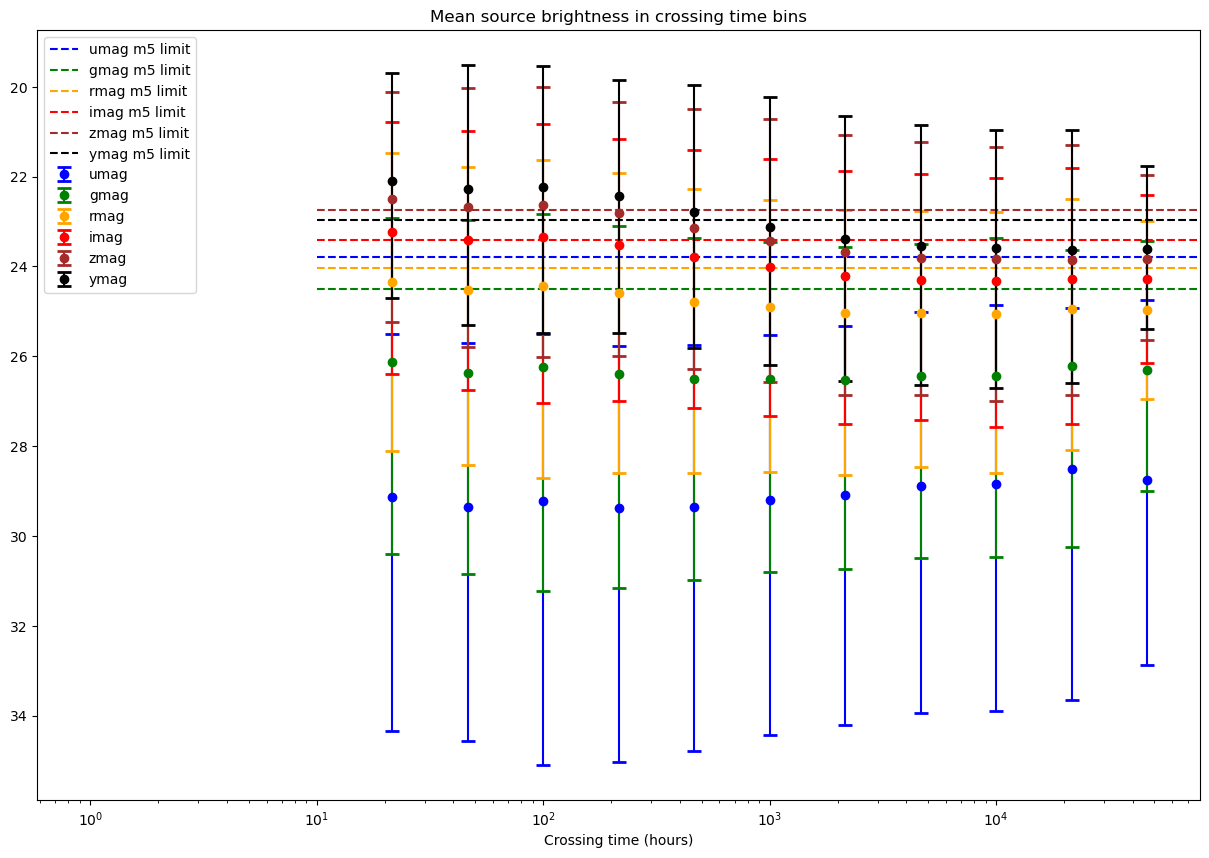

In [89]:
# bins=np.logspace(1,5,4*8+1)
bins=np.logspace(1,5,4*3+1)
percentiles = [50+44.6,50-44.6]
plt.figure(figsize=(15,10))
for filter in [col for col in full_event_df.columns if 'mag' in col]:
    brightness_crossing_time = np.array(bin_func(full_event_df, 'crossing_time', bins, mean_of_col, [filter]))
    # brightness_crossing_time_std = np.array(bin_func(full_event_df, 'crossing_time', bins, std_of_col, [filter]))
    brightness_crossing_time_percentiles = np.array(bin_func(full_event_df, 'crossing_time', bins, perc_of_col, filter, percentiles)).T
    brightness_crossing_time_errs = np.abs(brightness_crossing_time_percentiles - np.vstack([brightness_crossing_time, brightness_crossing_time]))
    plt.errorbar(bins[:-1], brightness_crossing_time, brightness_crossing_time_errs, label=filter, marker='o', linestyle='None', capsize=5,capthick=2,color=color_filter[filter[0]])
    plt.xscale('log')
    plt.title(f'Mean source brightness in crossing time bins')
    plt.xlabel('Crossing time (hours)')
    plt.hlines(single_exp_m5[filter[0]],bins[0],bins[-1],color=color_filter[filter[0]],linestyle='dashed', label=f'{filter} m5 limit')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_59274/2361972333.py:9: RuntimeWarning: Mean of empty slice.
  return events[meancol].to_numpy().mean()
/Users/duncan/mambaforge/envs/rubinsim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_59274/2361972333.py:9: RuntimeWarning: Mean of empty slice.
  return events[meancol].to_numpy().mean()
/Users/duncan/mambaforge/envs/rubinsim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_59274/2361972333.py:9: RuntimeWarning: Mean of empty slice.
  return events[meancol].to_numpy().mean()
/Users/duncan/mambaforge/envs/rubinsim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value enco

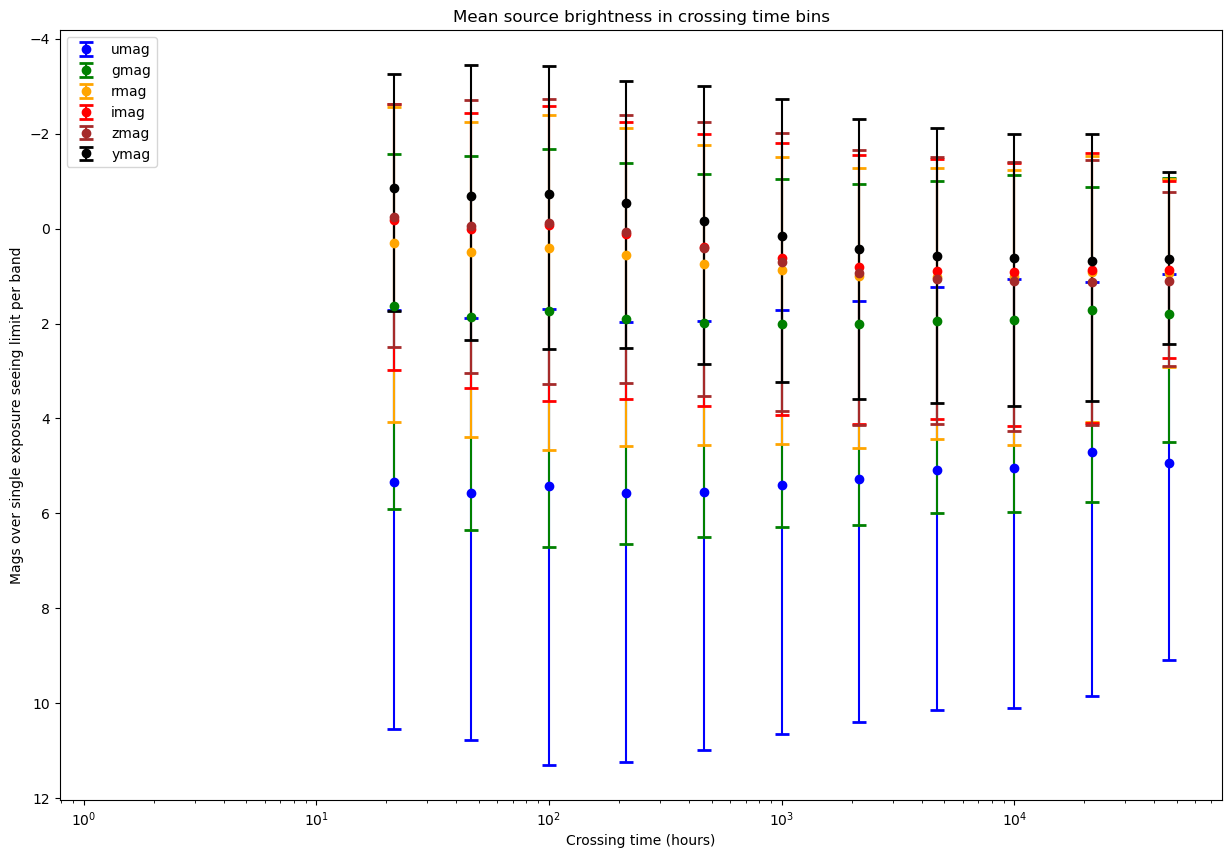

In [90]:
# bins=np.logspace(1,5,4*8+1)
bins=np.logspace(1,5,4*3+1)
percentiles = [50+44.6,50-44.6]
plt.figure(figsize=(15,10))
for filter in [col for col in full_event_df.columns if 'mag' in col]:
    brightness_crossing_time = np.array(bin_func(full_event_df, 'crossing_time', bins, mean_of_col, [filter]))
    # brightness_crossing_time_std = np.array(bin_func(full_event_df, 'crossing_time', bins, std_of_col, [filter]))
    brightness_crossing_time_percentiles = np.array(bin_func(full_event_df, 'crossing_time', bins, perc_of_col, filter, percentiles)).T
    brightness_crossing_time_errs = np.abs(brightness_crossing_time_percentiles - np.vstack([brightness_crossing_time, brightness_crossing_time]))
    plt.errorbar(bins[:-1], brightness_crossing_time-single_exp_m5[filter[0]], brightness_crossing_time_errs, label=filter, marker='o', linestyle='None', capsize=5,capthick=2,color=color_filter[filter[0]])
    plt.xscale('log')
    plt.title(f'Mean source brightness in crossing time bins')
    plt.xlabel('Crossing time (hours)')
    plt.ylabel('Mags over single exposure seeing limit per band')
    # plt.hlines(single_exp_m5[filter[0]],bins[0],bins[-1],color=color_filter[filter[0]],linestyle='dashed', label=f'{filter} m5 limit')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_59274/2361972333.py:9: RuntimeWarning: Mean of empty slice.
  return events[meancol].to_numpy().mean()
/Users/duncan/mambaforge/envs/rubinsim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


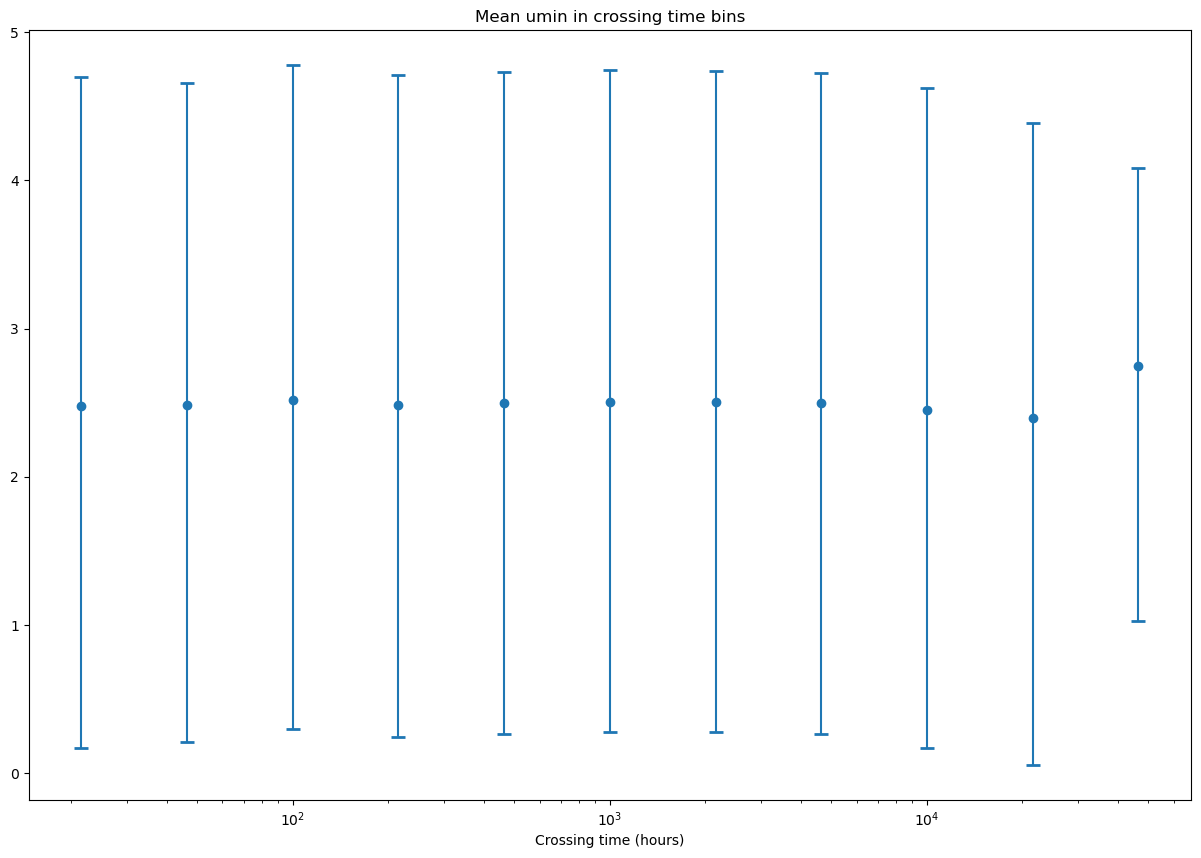

In [91]:
bins=np.logspace(1,5,4*3+1)
percentiles = [50+44.6,50-44.6]
bin_col = 'crossing_time'
y_col = 'umin'
plt.figure(figsize=(15,10))
umin_crossing_time = np.array(bin_func(full_event_df, bin_col, bins, mean_of_col, [y_col]))
# brightness_crossing_time_std = np.array(bin_func(full_event_df, 'crossing_time', bins, std_of_col, [filter]))
umin_crossing_time_percentiles = np.array(bin_func(full_event_df, bin_col, bins, perc_of_col, y_col, percentiles)).T
umin_crossing_time_errs = np.abs(umin_crossing_time_percentiles - np.vstack([umin_crossing_time, umin_crossing_time]))
plt.errorbar(bins[:-1], umin_crossing_time, umin_crossing_time_errs, marker='o', linestyle='None', capsize=5,capthick=2)
plt.xscale('log')
plt.title(f'Mean umin in crossing time bins')
plt.xlabel('Crossing time (hours)')
# plt.legend()

plt.show()

# ^very few short crossing time events

/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_59274/2361972333.py:9: RuntimeWarning: Mean of empty slice.
  return events[meancol].to_numpy().mean()
/Users/duncan/mambaforge/envs/rubinsim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


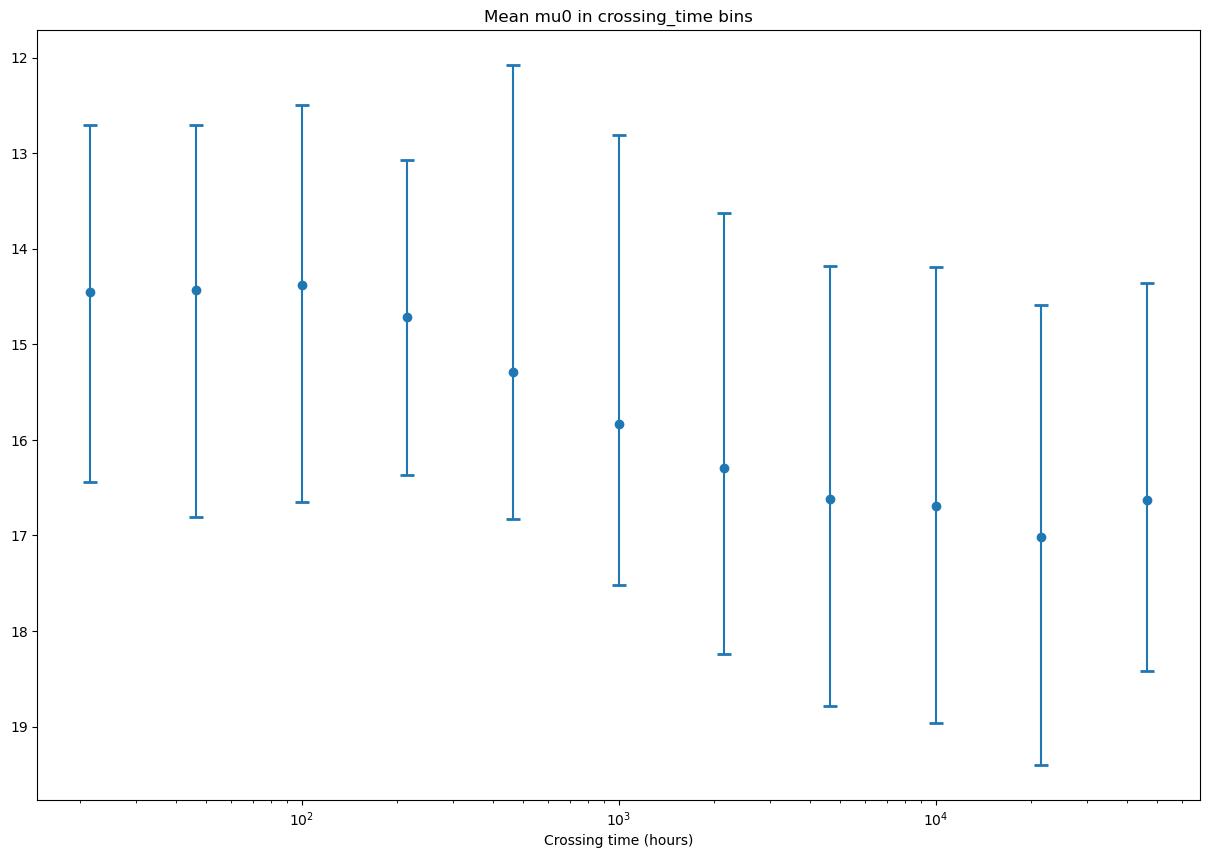

In [92]:
bins=np.logspace(1,5,4*3+1)
percentiles = [50+44.6,50-44.6]
bin_col = 'crossing_time'
y_col = 'mu0'
plt.figure(figsize=(15,10))
umin_crossing_time = np.array(bin_func(full_event_df, bin_col, bins, mean_of_col, [y_col]))
# brightness_crossing_time_std = np.array(bin_func(full_event_df, 'crossing_time', bins, std_of_col, [filter]))
umin_crossing_time_percentiles = np.array(bin_func(full_event_df, bin_col, bins, perc_of_col, y_col, percentiles)).T
umin_crossing_time_errs = np.abs(umin_crossing_time_percentiles - np.vstack([umin_crossing_time, umin_crossing_time]))
plt.errorbar(bins[:-1], umin_crossing_time, umin_crossing_time_errs, marker='o', linestyle='None', capsize=5,capthick=2)
plt.xscale('log')
plt.title(f'Mean {y_col} in {bin_col} bins')
plt.xlabel('Crossing time (hours)')
# plt.legend()
plt.gca().invert_yaxis()
plt.show()

Text(0.5, 1.0, 'Map of microlensing events')

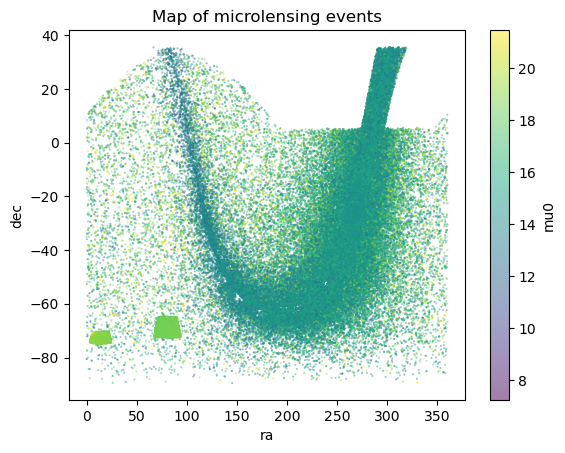

In [93]:
catalog.iloc[samples_arr[:,0]].plot.scatter(x='ra',y='dec', alpha=.5, marker=".",s=1, c='mu0')
plt.title('Map of microlensing events')

In [94]:
df = full_event_df.copy()

In [95]:
df['detected'] = detections

In [96]:
df['detected']

0         0.0
1         0.0
2         1.0
3         0.0
4         0.0
         ... 
336260    0.0
336261    0.0
336262    0.0
336263    0.0
336264    0.0
Name: detected, Length: 336265, dtype: float64

In [102]:
df.dtypes

source_index       int64
dl               float64
umin             float64
crossing_time    float64
lograte          float64
index              int64
ra               float64
dec              float64
gall             float64
galb             float64
umag             float64
gmag             float64
rmag             float64
imag             float64
zmag             float64
ymag             float64
mu0              float64
detected         float64
dtype: object

In [104]:
detected_df = df[df['detected']==1]

In [107]:
detected_df.drop('detected', axis=1,inplace=True)
detected_df

/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_59274/3828794282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detected_df.drop('detected', axis=1,inplace=True)


source_index         dl      umin  crossing_time    lograte   index  \
2             954024   6.352935  1.688565    1770.543617 -23.982610  954024   
5             968245   7.395280  0.925944    1786.751373 -23.587797  968245   
6             261245   3.972774  1.293267    1940.108707 -23.210766  261245   
10            455837   4.158837  0.793772     831.376705 -22.867253  455837   
16            846506  11.969760  0.224991    1685.151795 -23.067106  846506   
...              ...        ...       ...            ...        ...     ...   
336248         49072   2.105746  0.052852     450.270545 -23.719317   49072   
336249         55222   3.646046  1.124274    1107.367595 -23.575978   55222   
336250        385824   2.292539  0.890552     675.996559 -23.369712  385824   
336252        706652   9.329151  0.504959     942.106591 -23.022580  706652   
336259        216600   6.835892  0.306680    1756.236039 -24.089820  216600   

                ra        dec        gall       galb    umag    gmag    rmag  \
2        81.571713 -69.574242  280.202639 -32.688944  24.970  24.035  23.657   
5        11.375611 -72.971429  303.537493 -44.149843  25.247  24.213  23.796   
6       228.077881 -59.711529  319.847637  -1.549057  26.681  23.672  21.457   
10      266.575776 -21.491281    6.446598   3.735052  27.725  24.549  22.897   
16       83.936277 -65.306898  275.046698 -32.334599  23.572  22.547  22.314   
...            ...        ...         ...        ...     ...     ...     ...   
336248  274.169306 -31.723694    0.874609  -7.203171  23.104  21.061  20.223   
336249  261.204273 -38.526677  349.598308  -1.552387  29.783  26.975  24.800   
336250  253.114808 -41.231436  343.722151   1.807003  29.563  26.032  23.853   
336252  268.245399  -3.248347   23.222925  11.440588  25.781  23.779  22.697   
336259   82.154609 -68.846374  279.309845 -32.602591  28.450  26.404  25.525   

          imag    zmag    ymag     mu0  
2       23.521  23.473  23.456  18.487  
5       23.628  23.542  23.505  18.908  
6       20.094  18.913  18.267  14.850  
10      22.098  21.530  21.214  14.550  
16      22.257  22.248  22.241  18.451  
...        ...     ...     ...     ...  
336248  19.911  19.741  19.648  14.250  
336249  23.493  22.481  21.928  15.450  
336250  22.672  21.782  21.290  13.850  
336252  22.169  21.812  21.620  15.300  
336259  25.175  24.988  24.878  18.485  

[107910 rows x 17 columns]

In [108]:
detected_df.to_pickle(basedir+f'/1sm_baseline_detected_df.pickle')

In [97]:
# umin_bins=np.linspace(0,u_t,4*8+1)
umin_bins=np.linspace(0,u_t,10*8+1)

NameError: name 'u_t' is not defined

NameError: name 'umin_bins' is not defined

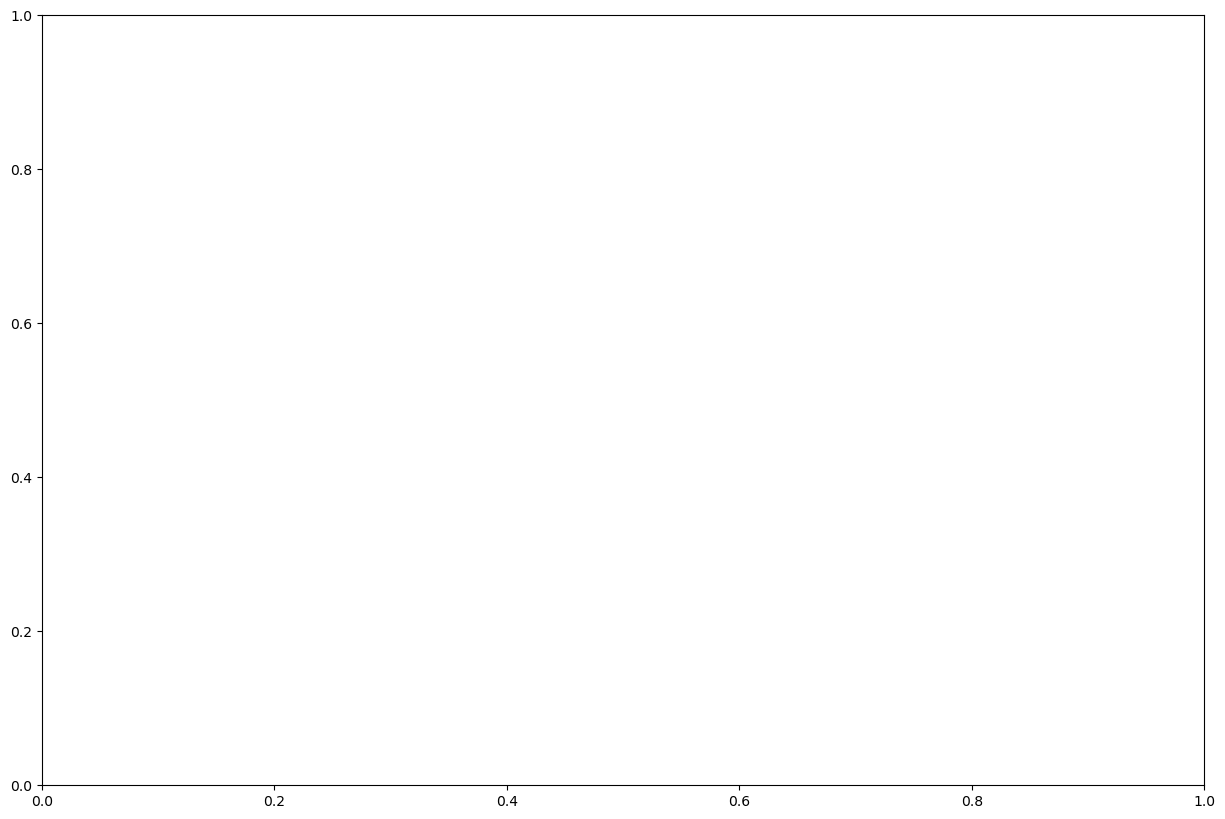

In [98]:
fig,ax=plt.subplots(figsize=(15,10))
df['umin_bin'] = pd.cut(df['umin'],umin_bins)
df_det_umin = df.groupby(['umin_bin','detected'])['detected'].count().unstack()#.fillna(0)
df_det_umin.plot(kind='bar', stacked=True,ax=ax)
plt.title('(Non)detections in bins of impact parameters')

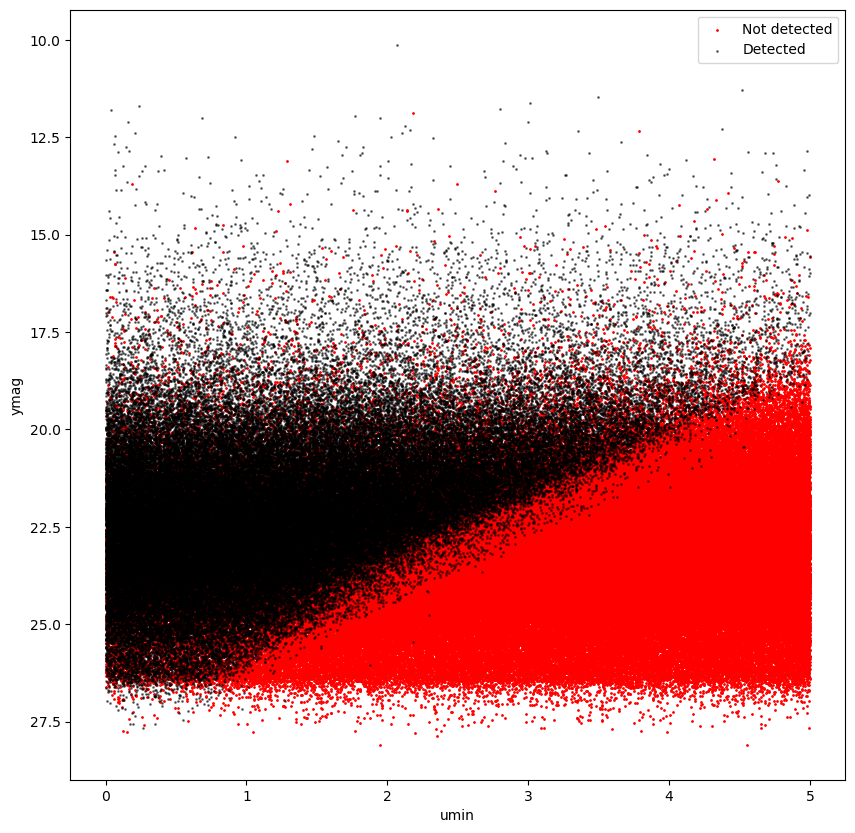

In [99]:
fig,ax=plt.subplots(figsize=(10,10))
df[df['detected']==0].plot.scatter('umin','ymag', c='red',ax=ax,alpha=1,s=1,label='Not detected')
df[df['detected']==1].plot.scatter('umin','ymag', c='black',ax=ax,alpha=.5,s=1, label='Detected')
ax.invert_yaxis()
ax.legend()
plt.show()

In [100]:
df[df['detected']==1].sort_values('umin',ascending=False)

source_index        dl      umin  crossing_time    lograte   index  \
205524         28177  5.810743  4.998577     787.949049 -22.958299   28177   
57646         860135  4.851111  4.997616     486.869643 -22.694789  860135   
157249        157324  2.443622  4.997241     506.867970 -23.850301  157324   
21056         907211  5.828879  4.995557     444.468421 -22.586246  907211   
109295        214882  8.301500  4.995441     285.358619 -21.967885  214882   
...              ...       ...       ...            ...        ...     ...   
300799        429319  0.930647  0.000096     533.907184 -25.359732  429319   
90069         619469  8.892324  0.000057     641.800689 -22.004633  619469   
265974        821794  6.648848  0.000047   21918.732614 -30.503257  821794   
59399         989825  7.219927  0.000037     744.916997 -21.969016  989825   
75269         649236  1.030613  0.000023     257.824659 -25.060014  649236   

                ra        dec        gall       galb    umag    gmag    rmag  \
205524  267.135994 -34.928973  355.189619  -3.631661  22.666  18.870  17.158   
57646   259.470369 -34.200862  352.360988   2.057322  25.791  22.189  19.421   
157249  173.233325 -56.314661  292.155599   4.905705  21.602  19.092  17.971   
21056   267.073491 -34.561038  355.479550  -3.398701  21.910  18.818  17.329   
109295  258.978801 -39.418954  347.877322  -0.642051  23.338  19.813  17.202   
...            ...        ...         ...        ...     ...     ...     ...   
300799  129.018293  -6.407717  231.469252  19.817218  24.172  21.595  20.404   
90069   260.311860 -30.522119  355.789737   3.577450  28.088  24.604  22.647   
265974  285.756769 -30.293124    6.481043 -15.595956  31.270  28.664  27.292   
59399   271.722186 -26.081353    4.839869  -2.640365  31.086  27.266  25.052   
75269   272.080516 -26.007039    5.061125  -2.885987  23.209  20.179  18.520   

          imag    zmag    ymag    mu0  detected  
205524  16.359  15.831  15.545  14.60       1.0  
57646   17.823  16.649  15.995  14.65       1.0  
157249  17.490  17.180  17.012  14.60       1.0  
21056   16.631  16.140  15.876  15.00       1.0  
109295  15.735  14.610  13.991  14.70       1.0  
...        ...     ...     ...    ...       ...  
300799  19.883  19.632  19.494  12.35       1.0  
90069   21.638  20.890  20.481  14.90       1.0  
265974  26.676  26.341  26.157  15.80       1.0  
59399   23.926  23.129  22.678  14.85       1.0  
75269   17.653  17.029  16.682  14.65       1.0  

[107910 rows x 18 columns]

Text(0.5, 1.0, 'Histogram of detected events in umin bins with shot noise')

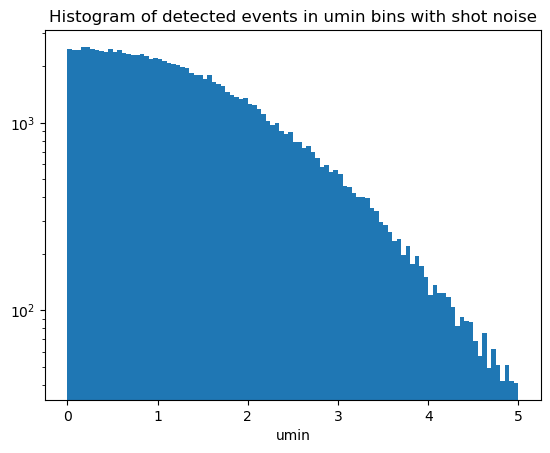

In [101]:
plt.hist(df[df['detected']==1]['umin'], bins=100);
plt.yscale('log')
plt.xlabel('umin')
plt.title('Histogram of detected events in umin bins with shot noise')

In [113]:
rs_bundle = list(bundles.values())[0]

In [116]:
df.value_counts(subset=['umin_bin','detected'])

umin_bin         detected
(1.938, 2.0]     0.0         8402
                 1.0         6527
(1.875, 1.938]   0.0         6342
(1.812, 1.875]   0.0         5495
(1.875, 1.938]   1.0         5183
                             ... 
(0.25, 0.312]    0.0         1624
(0.375, 0.438]   0.0         1595
(0.188, 0.25]    0.0         1584
(0.125, 0.188]   0.0         1543
(0.0625, 0.125]  0.0         1521
Name: count, Length: 64, dtype: int64

In [133]:
df_det = df[df['detected']==1]

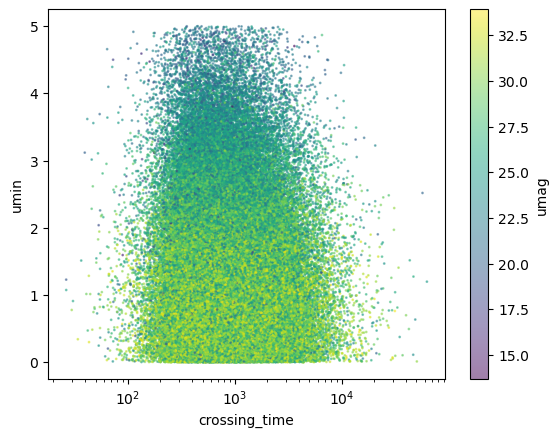

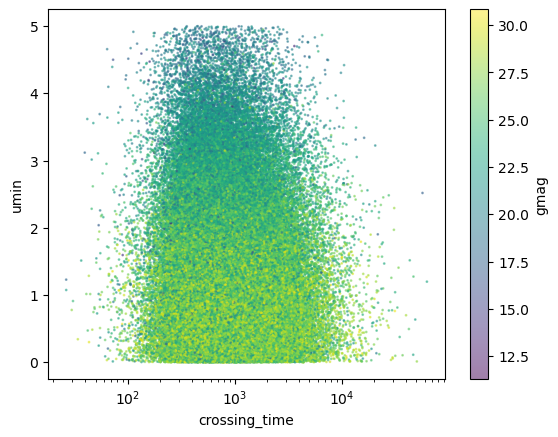

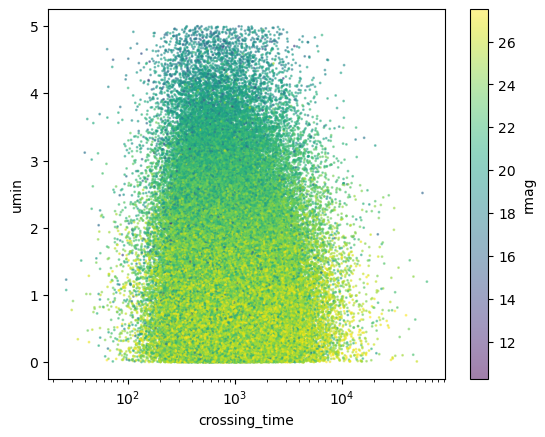

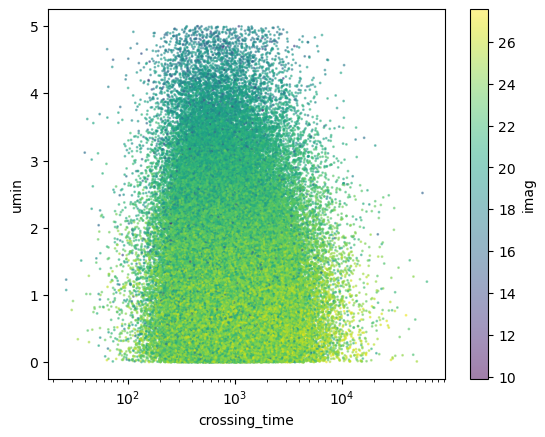

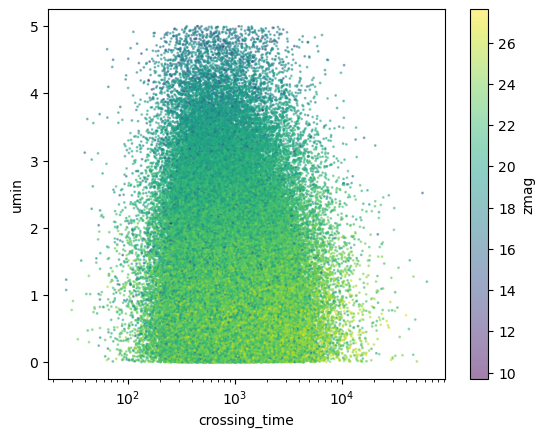

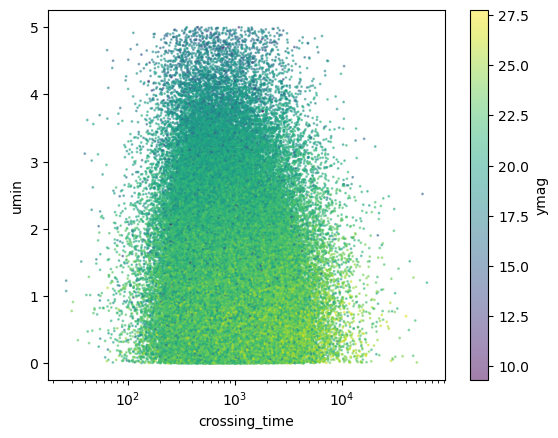

In [134]:
for filter in df_det.columns:
    if 'mag' not in filter:
        continue
    df_det.plot.scatter('crossing_time','umin', alpha=.5,s=1, c=filter)
    plt.xscale('log')
    plt.show()

23.302374999999998


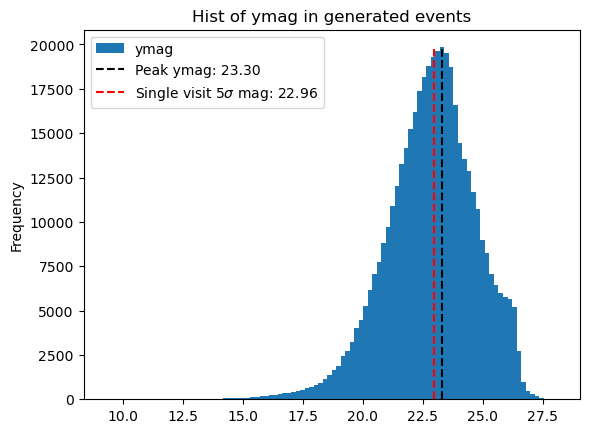

In [136]:
nums, bins = np.histogram(df['ymag'], bins=100)
maxbin = (bins[np.argmax(nums)]+bins[np.argmax(nums)+1])/2
print(maxbin)
fig,ax = plt.subplots()
df['ymag'].plot.hist(ax=ax,bins=100, title='Hist of ymag in generated events')
ax.vlines(maxbin, min(nums), max(nums),color='black', linestyle='dashed', label=f'Peak ymag: {maxbin:.2f}')
ax.vlines(22.96, min(nums), max(nums),color='red', linestyle='dashed', label=fr'Single visit 5$\sigma$ mag: {22.96}')
plt.legend()
plt.show()

# Npts metric

In [238]:
npts = list(bundles_Npts.values())[0].metric_values

In [240]:
df['npts'] = npts

/tmp/ipykernel_3890/1461869471.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_npts_umin = ((df[df['npts']>=npts_thresh]).groupby(['umin_bin'])['npts']).count()#.unstack()#.fillna(0)


Text(0.5, 1.0, 'Number of curves with over 5 detected points in bins of impact parameters')

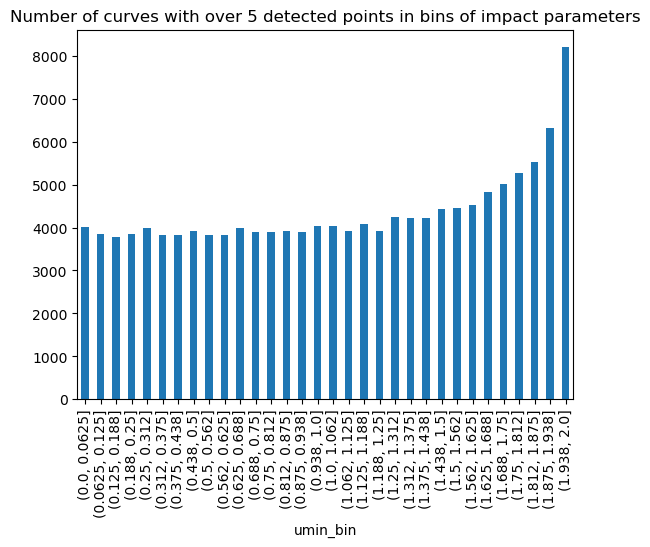

In [253]:
npts_thresh=5
df_npts_umin = ((df[df['npts']>=npts_thresh]).groupby(['umin_bin'])['npts']).count()#.unstack()#.fillna(0)
df_npts_umin.plot(kind='bar', stacked=True)
plt.title(f'Number of curves with over {npts_thresh} detected points in bins of impact parameters')

/tmp/ipykernel_3890/2137581379.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_npts_umin = ((df).groupby(['umin_bin'])['npts']).mean()#.unstack()#.fillna(0)


Text(0.5, 1.0, 'Mean number of detected points in bins of impact parameters')

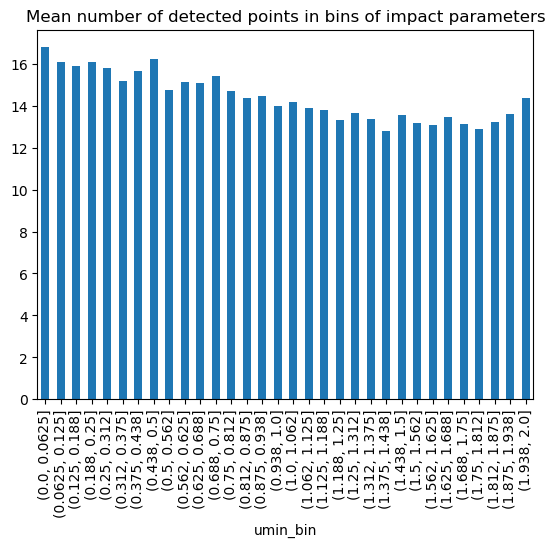

In [254]:
df_npts_umin = ((df).groupby(['umin_bin'])['npts']).mean()#.unstack()#.fillna(0)
df_npts_umin.plot(kind='bar', stacked=True)
plt.title(f'Mean number of detected points in bins of impact parameters')

In [ ]:
# Illustrate some things about the metric values: (caught in summary metrics)
m = list(bundles.keys())[-1]
print(f'How many lightcurves were added? (over the entire sky) {len(bundles[m].metric_values)}')
print(f'How many lightcurves were added in areas that were part of the survey footprint?' ,
      f'{len(bundles[m].metric_values.compressed())}')
print(f'What are the metric values for each of these light curves? '
      f'{np.unique(bundles[m].metric_values.compressed())}')
print(f'How many lightcurves were *successfully* detected? {bundles[m].metric_values.sum()}')
print(len(np.where(bundles[m].metric_values == 1)[0]))
frac_total = bundles[m].metric_values.sum() / len(bundles[m].metric_values)
print(f'Fraction of total lightcurves detected {frac_total}')
frac_footprint = bundles[m].metric_values.sum() / len(bundles[m].metric_values.compressed())
print(f'Fraction of lightcurves within footprint detected {frac_footprint}')

In [ ]:
d_Npts = pd.DataFrame([bundles_Npts[k].summary_values for k in bundles_Npts.keys()], index=list(bundles_Npts.keys()))
d_Npts

In [ ]:
d_Fisher = pd.DataFrame([bundles_Fisher[k].summary_values for k in bundles_Fisher.keys()],\
                        index=list(bundles_Fisher.keys()))
d_Fisher

## Preparing metric results and creating figure of merit and comparison plots

In [ ]:
results = []
results_compare = []
run_names = []
metric_types = []
min_tEs = []
max_tEs = []

bundle_dicts = [bundles, bundles_Npts, bundles_Fisher]

for bundle_dict in range(len(bundle_dicts)):
    if bundle_dict == 0: #detect metric
        results.extend(d['Fraction detected of total (mean)'])
        #results_compare.extend(d['Fraction detected of total (mean)'])
        metric_types.extend(['detect']*len(bundles.keys()))
    elif bundle_dict == 1: #Npts metric
        results.extend(d_Npts['Mean number of points per lightcurves in total'])
        #results_compare.extend(d_Npts['Fraction w/ at least 10 points'])
        metric_types.extend(['Npts']*len(bundles_Npts.keys()))
    elif bundle_dict == 2: #Fisher metric
        results.extend(d_Fisher['Fraction w/ sigma_tE/tE < 0.1'])
        #results_compare.extend(d_Fisher['Fraction w/ sigma_tE/tE < 0.1'])
        metric_types.extend(['Fisher']*len(bundles_Fisher.keys()))
    for i in bundle_dicts[bundle_dict]:
        results_compare.append(bundle_dicts[bundle_dict][i].metric_values)
        run_names.append(bundle_dicts[bundle_dict][i].run_name)
        min_tEs.append(np.int(i.split(' ')[0]))
        max_tEs.append(np.int(i.split(' ')[2]))
        
results = np.array(results)
results_compare = np.array(results_compare)
run_names = np.array(run_names)
metric_types = np.array(metric_types)
min_tEs = np.array(min_tEs)
max_tEs = np.array(max_tEs)

The following figure is intended to be used to compare between different OpSims

In [ ]:
save_folder = 'test_microlensing'
figure_name = 'microlensingFOM'
figsize = (30, 5) # Increase 5 for more metrics
maf.plot_fom(results, run_names, metric_types, min_tEs, max_tEs, save_folder, figure_name, figsize = figsize)

The following set of figures compares between the discovery/detect metric, number of points metric, and characterization/fisher metric. By default the fraction discovered, the fraction of objects with at least 10 points within 2tE of the peak, and the fraction characterized are compared. The three should all be correlated, but these plots are helpful for knowing how much followup must be done outside of Rubin to characterize events.

In [ ]:
maf.plot_compare(results_compare, run_names, metric_types, min_tEs, max_tEs, save_folder)

## Look at the slicer information (how the lightcurves were added). ##

In [ ]:
# The *slicer* keeps the information about the injected lightcurves too
slicer = bundles[m].slicer
print(f'How many lightcurves added over the sky? {len(slicer)}')

In [ ]:
# What information was recorded for each event
slicer.slice_points.keys()

In [ ]:
# Including their spatial, time and distance distribution
hp.mollview(rsUtils._healbin(slicer.slice_points['ra'], slicer.slice_points['dec'], 
                             slicer.slice_points['peak_time'], 64, reduce_func=np.mean), 
            unit='peak time (days)', title='Lightcurve Peak Times', min=0, max=3650)